In [1]:
import os
import warnings

import math
import pycbc
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from gwpy.timeseries import TimeSeries
from matplotlib.ticker import ScalarFormatter
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, auc
from IPython.display import display

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

warnings.filterwarnings('ignore')

/home/ashishthomas.mathew/.conda/envs/gengli_env/lib/python3.12/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


In [2]:
from modules import statistical_testing

In [3]:
glitches = pd.read_csv('./glitches/O3a_allifo.csv', usecols=['GPStime', 'snr', 'duration', 'confidence', 'ifo', 'label'])
glitches = glitches[~glitches.duplicated(subset=['GPStime'], keep='first')]
glitches = glitches[glitches["ifo"] == "L1"]

glitches.columns

Index(['GPStime', 'snr', 'duration', 'confidence', 'ifo', 'label'], dtype='object')

# Testing our normality tests on a combined dataset of glitches and clean data

In this case we have a rather unique challenge where the data at hand is fairly unbalanced, with variations in the number of glitches and clean samples. Hence, for this case I'll take around 1000 samples of each to see how things go.

Our data with glitches has a lot more information to work with such as snr, duration and confidence, which we will not be taking into consideration for now since we want to look at what is common betwen clean and glitches samples.

Additionally our glitches are marked by particular GPS times around which we need to consider a time window to whiten and crop the sample into workable segments for our statistical tests. Our clean data is in the form of time segments of relative "silence" which we will have to process as is and divide into equally sized segments as our glitch data. 

## Loading the data

Let's generate this dataset below

In [4]:
glitch_count_df = glitches["label"].value_counts().rename_axis('Glitch Class').reset_index(name='Count')
glitch_count_df.to_latex("./outputs/glitch_counts.tex", index=False, float_format="%.0f", escape=False)

In [5]:
selection = glitches[(glitches['label'] == 'Tomte')]
samples = statistical_testing.fetch_glitch_data_from_csv(selection, begin=0, n_samples=10)

<class 'int'> <class 'int'> <class 'int'>
Time elapsed for q-transform: 0.15 seconds


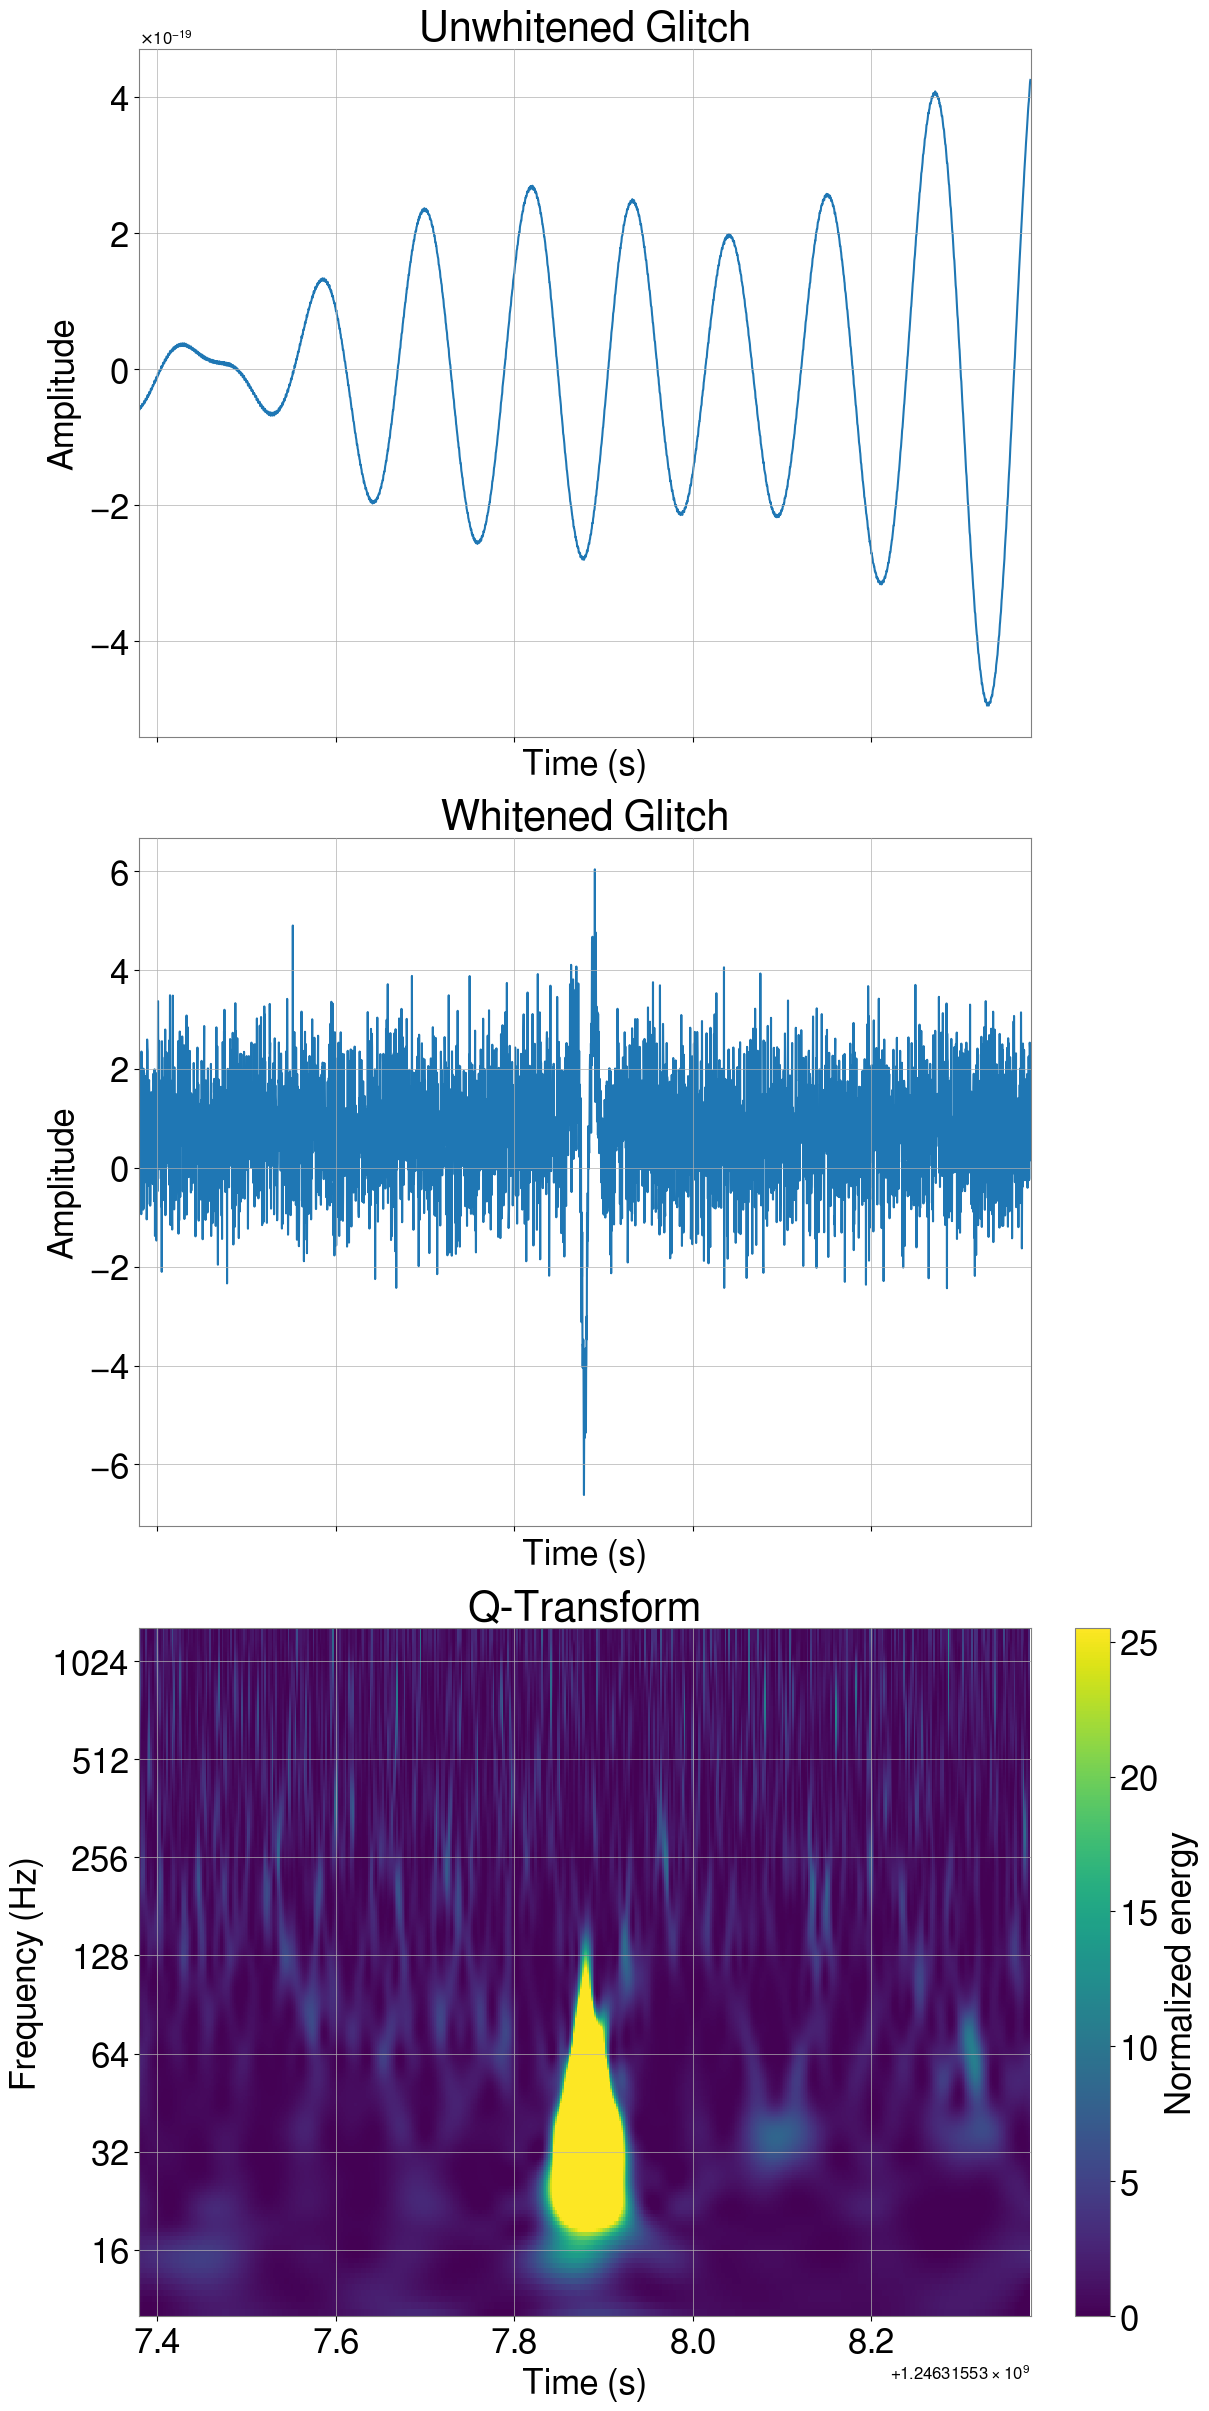

In [6]:
statistical_testing.display_sample_plots(samples.iloc[9], save_path="./outputs/sample_plot.pdf")

In [7]:
samples.columns

Index(['GPStime', 'snr', 'duration', 'confidence', 'ifo', 'label',
       'unwhitened_y', 'whitened_y', 't', 'timeseries_file_location',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'glitch_present'],
      dtype='object')

In [8]:
sample_timeseries = TimeSeries.read(samples["timeseries_file_location"].iloc[0])

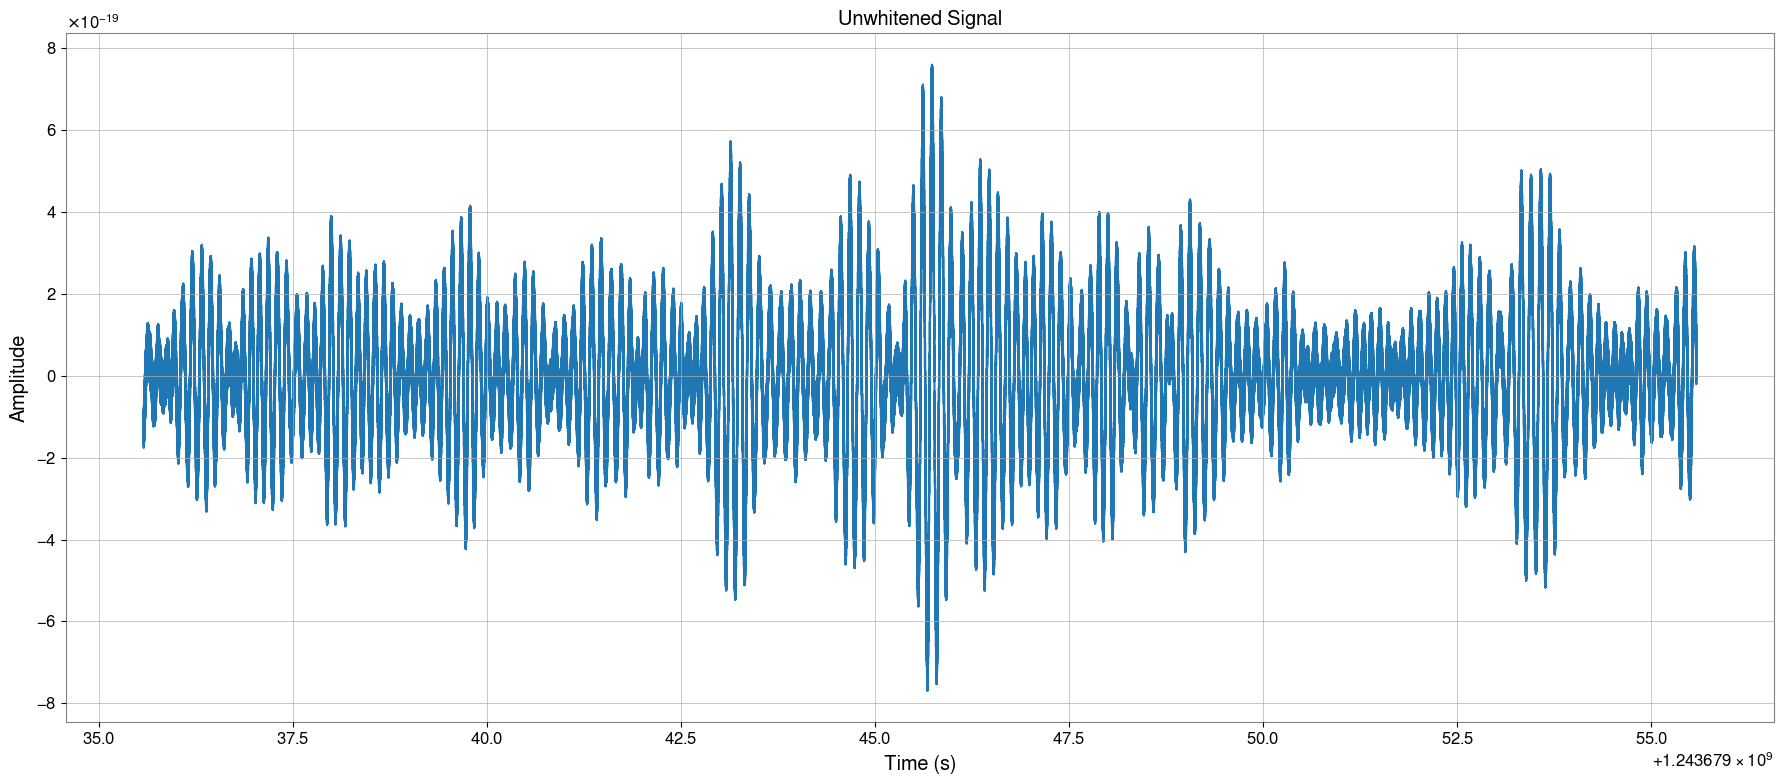

In [9]:
# plot the unwhitened y values for the first chirp
fig = plt.figure(figsize=(18, 8))
plt.plot(sample_timeseries.times, sample_timeseries.value)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Unwhitened Signal")
plt.tight_layout()
plt.savefig("./outputs/unwhitened_signal.pdf", dpi=100)

In [10]:
#whiten the timeseries
sample_timeseries_whitened = sample_timeseries.whiten(4,2)

In [11]:
sample_timeseries_whitened = sample_timeseries_whitened[int(4096*4):-int(4096*4)]

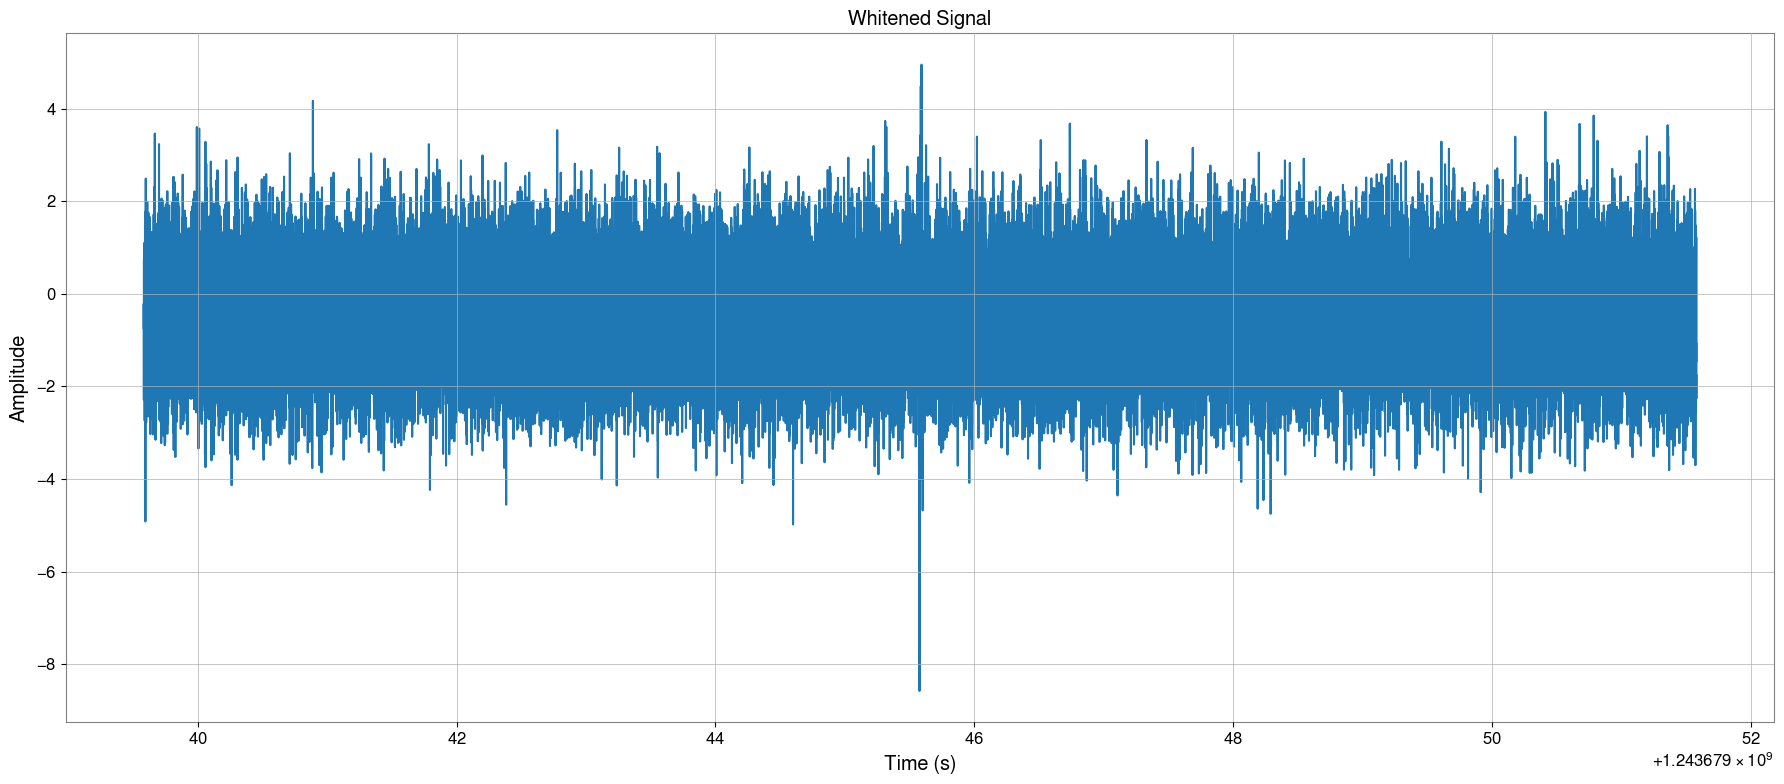

In [12]:
plt.figure(figsize=(18, 8))
plt.plot(sample_timeseries_whitened.times, sample_timeseries_whitened.value)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Whitened Signal")
plt.tight_layout()
plt.savefig("./outputs/whitened_signal.pdf", dpi=100)

In [13]:
sample_asd = sample_timeseries.asd(4, 2)

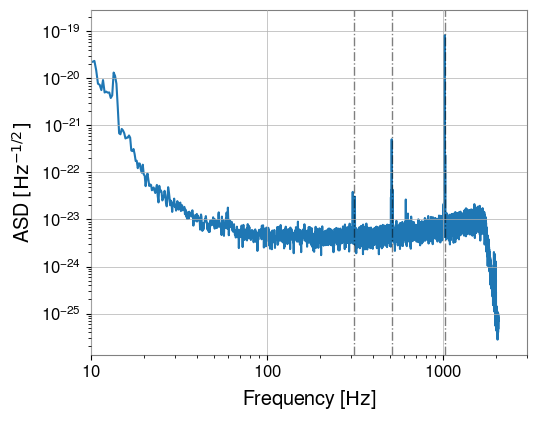

In [14]:
plot = sample_asd.plot()
ax = plot.gca()
ax.set_xlim(10, 3000)
# ax.set_ylim(5e-26, 1e-21)

#plot dotted lines at 512 Hz and 1024Hz
ax.axvline(x=310, color='black', linestyle='-.', linewidth=1, alpha=0.5)
ax.axvline(x=510, color='black', linestyle='-.', linewidth=1, alpha=0.5)
ax.axvline(x=1020, color='black', linestyle='-.', linewidth=1, alpha=0.5)
ax.set_ylabel("ASD $[\mathrm{Hz}^{-1/2}]$")

plot.savefig("./outputs/unwhitened_asd.pdf", dpi=100)

In [15]:
labels = ['1080Lines', '1400Ripples', 'Air_Compressor', 'Blip',
       'Blip_Low_Frequency', 'Chirp', 'Extremely_Loud',
       'Fast_Scattering', 'Helix', 'Koi_Fish',
       'Light_Modulation', 'Low_Frequency_Burst',
       'Low_Frequency_Lines', 'Paired_Doves',
       'Power_Line', 'Repeating_Blips', 'Scattered_Light',
       'Scratchy', 'Tomte', 'Violin_Mode', 'Wandering_Line',
       'Whistle', 'clean_signal']

columns = [
    'label', "shapiro_TP", "shapiro_FN",
    "shapiro_FP", "shapiro_TN", "shapiro_accuracy", "shapiro_recall", "shapiro_fpr",
    "shapiro_precision", "shapiro_f1_score", "KS_TP",
    "KS_FN", "KS_FP", "KS_TN",
    "KS_accuracy", "KS_recall", "KS_fpr", "KS_precision",
    "KS_f1_score", "AD_TP", "AD_FN", "AD_FP", "AD_TN",
    "AD_accuracy", "AD_recall", "AD_fpr", "AD_precision", "AD_f1_score"]


def generate_glitchwise_confusion_matrices(df):

    scaler = StandardScaler()

    confusion_matrix_df = pd.DataFrame(columns=columns)
    for label in labels:
        temp_df = df[df['label'] == label]

        # print(f"Loading {label} data...")

        # temp_df = statistical_testing.fetch_glitch_data_from_csv(temp_df, tw=10, bandpass=bandpass, low_freq=low_feq, high_freq=high_freq)
        # temp_df.dropna(inplace=True)

        # print(f"Generating confusion matrix for {label}...")
        shapiro_cm = statistical_testing.generate_confusion_matrix(temp_df)
        ks_cm = statistical_testing.generate_confusion_matrix(temp_df, "KS")
        ad_cm = statistical_testing.generate_confusion_matrix(temp_df, "Anderson")

        shapiro_metrics = list(statistical_testing.generate_evaluation_metrics(shapiro_cm))
        ks_metrics = list(statistical_testing.generate_evaluation_metrics(ks_cm))
        ad_metrics = list(statistical_testing.generate_evaluation_metrics(ad_cm))

        shapiro_cm = shapiro_cm.flatten()
        ks_cm = ks_cm.flatten()
        ad_cm = ad_cm.flatten()

        confusion_matrix_df = pd.concat([confusion_matrix_df, pd.DataFrame([[label] + shapiro_cm.tolist() + shapiro_metrics + ks_cm.tolist() + ks_metrics + ad_cm.tolist() + ad_metrics], columns=columns)], ignore_index=True)

    return confusion_matrix_df
    

In [16]:
def generate_testwise_confusion_matrix(df):

    confusion_matrix_df = pd.DataFrame(columns=["Test","TP","FN","FP","TN","Accuracy","Recall(TPR/Sensitivity)", "FPR","Precision","F1 Score"])
    for test in ["Shapiro", "KS", "Anderson"]:
        # print(f"Generating confusion matrix for {test}...")
        cm = statistical_testing.generate_confusion_matrix(df, test)
        metrics = list(statistical_testing.generate_evaluation_metrics(cm))
        cm = cm.flatten()
        confusion_matrix_df = pd.concat([confusion_matrix_df, pd.DataFrame([[test] + cm.tolist() + metrics], columns=confusion_matrix_df.columns)], ignore_index=True)
    
    return confusion_matrix_df

In [17]:
# Loading up the clean segments
clean_gpstimes = pd.read_csv("./clean_segments/pre_clean_segments_O3a_L1.csv", usecols=['start_time', 'end_time', 'p_values'])

# Loading up the glitch data times and randomly sampling 51 glitches from each label
sample_glitches = pd.read_csv('./glitches/DQ_glitches_O3a.csv', usecols=['GPStime', 'ifo', 'label','snr'])
# Excluide 'no_glitch' label
sample_glitches = sample_glitches[sample_glitches['label'] != 'No_Glitch']
sample_glitches = sample_glitches[~sample_glitches.duplicated(subset=['GPStime'], keep='first')]


if not os.path.isfile("./glitches/random_samples.csv"):
    sample_glitches_df = sample_glitches[sample_glitches['ifo'] == 'L1'].groupby('label').apply(lambda x: x.sample(n=min(len(x),101))).reset_index(drop=True)
    sample_glitches_df.to_csv("./glitches/random_samples.csv", index=False)
else:
    sample_glitches_df = pd.read_csv("./glitches/random_samples.csv", index_col=False)

In [18]:
sample_glitches_df.head()

GPStime      snr ifo      label
0 1243645823.14600 10.26000  L1  1080Lines
1 1243586559.13700 11.94400  L1  1080Lines
2 1248843684.68100  8.48800  L1  1080Lines
3 1246314144.06300 12.84000  L1  1080Lines
4 1252075134.94000  9.38500  L1  1080Lines

In [19]:
def create_combined_glitch_clean_df(clean_gpstimes, sample_glitches_df, n_samples=1000, whitening_tw: int=10, observation_tw: float = 1, segment_duration_seconds: float=1, bandpass=False, low_freq=10, high_freq=250):
    clean_samples_df = statistical_testing.fetch_clean_segment_samples(clean_gpstimes, n_samples=n_samples, segment_duration_seconds=segment_duration_seconds, bandpass=bandpass, low_freq=low_freq, high_freq=high_freq)
    sample_glitches_df = statistical_testing.fetch_glitch_data_from_csv(sample_glitches_df, whitening_tw=whitening_tw, observation_tw=observation_tw, bandpass=bandpass, low_freq=low_freq, high_freq=high_freq)

    print(clean_samples_df.columns)
    print(sample_glitches_df.columns)
    # , 'shapiro_prediction', 'ks_prediction', 'ad_prediction'
    sample_glitches_df = sample_glitches_df[['whitened_y', 'unwhitened_y', 't', "timeseries_file_location", 'shapiro_statistic', 'shapiro_pvalue',
	    'ks_statistic', 'ks_pvalue', 'ad_statistic',
	    'ad_critical_values', 'ad_significance_level', 'kurtosis', 'skew',
	    'ifo', 'label', 'glitch_present', 'snr']]

    sample_glitches_df = sample_glitches_df.dropna()
    clean_samples_df = clean_samples_df.dropna()

    # Combining the clean and glitch data
    combined_df = pd.concat([clean_samples_df, sample_glitches_df], ignore_index=True)
    
    return combined_df

In [20]:
combined_df = create_combined_glitch_clean_df(clean_gpstimes[0:700], sample_glitches_df, n_samples=2000)

Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


In [21]:
combined_df[combined_df.isna().any(axis=1)].head()

Empty DataFrame
Columns: [whitened_y, t, timeseries_file_location, unwhitened_y, shapiro_statistic, shapiro_pvalue, ks_statistic, ks_pvalue, ad_statistic, ad_critical_values, ad_significance_level, kurtosis, skew, ifo, label, glitch_present, snr]
Index: []

In [22]:
len(combined_df)

3593

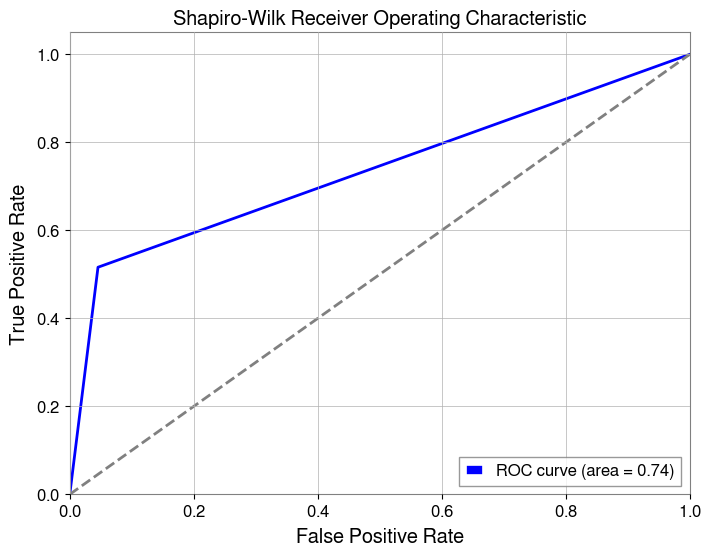

In [23]:
statistical_testing.display_auc_roc(combined_df['glitch_present'], combined_df['shapiro_pvalue'])

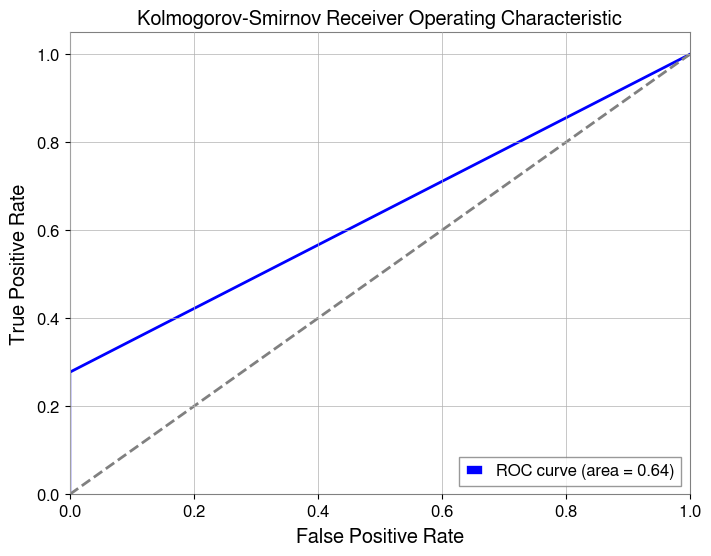

In [24]:
statistical_testing.display_auc_roc(combined_df['glitch_present'], combined_df['ks_pvalue'], "KS")

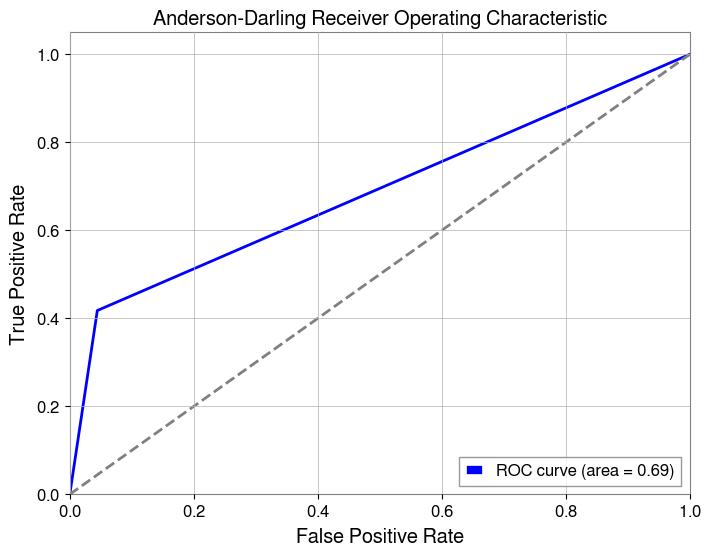

In [25]:
statistical_testing.display_auc_roc(combined_df['glitch_present'], combined_df[['ad_statistic','ad_critical_values']], "Anderson")

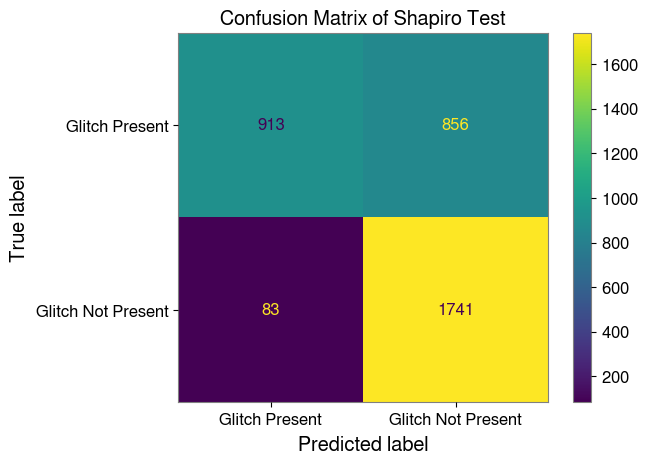

In [26]:
statistical_testing.display_confusion_matrix(combined_df)

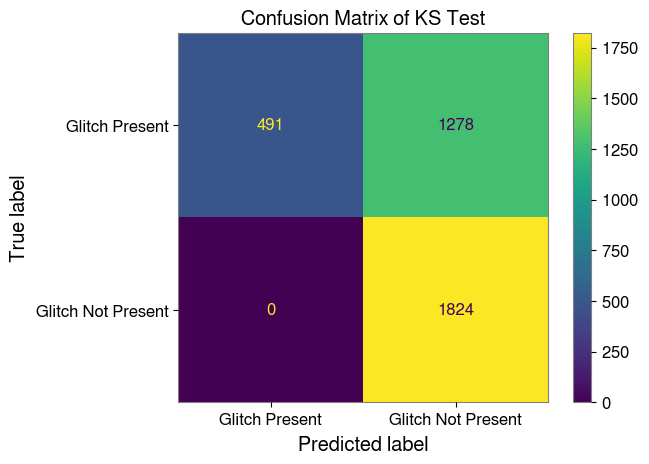

In [27]:
statistical_testing.display_confusion_matrix(combined_df, "KS")

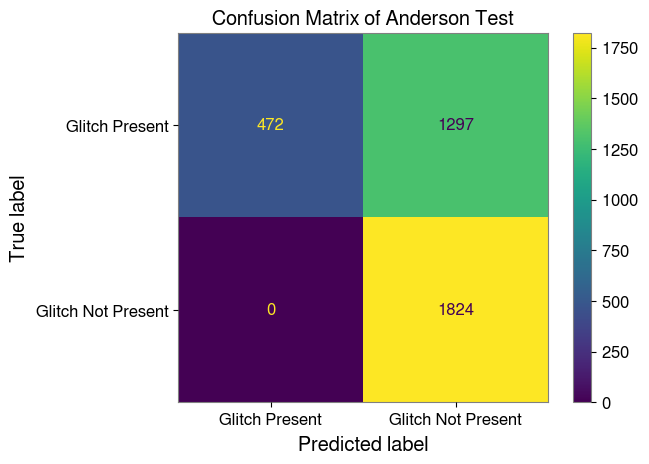

In [28]:
statistical_testing.display_confusion_matrix(combined_df, "Anderson")

I will now perform the same tests using a band pass filter

In [29]:
bp_combined_df = create_combined_glitch_clean_df(clean_gpstimes[0:700], sample_glitches_df, n_samples=2000, bandpass=True, low_freq=10, high_freq=1000)

Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


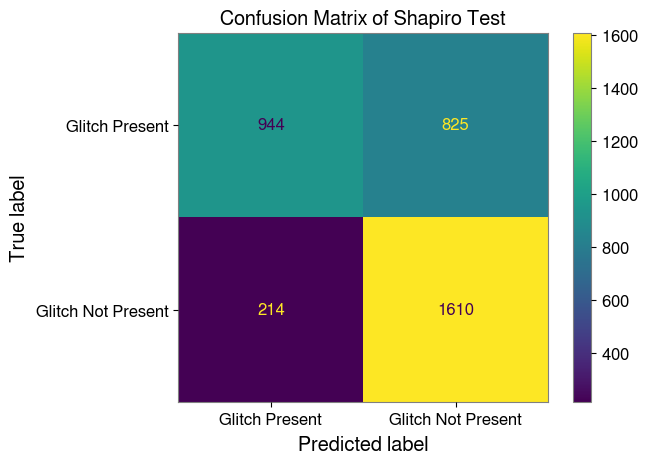

In [30]:
statistical_testing.display_confusion_matrix(bp_combined_df)

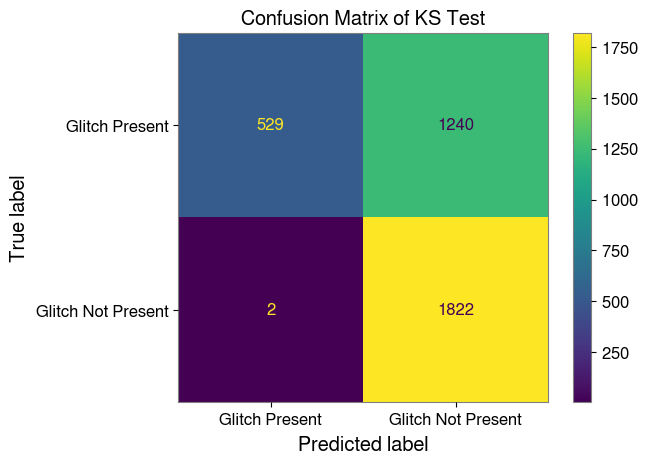

In [31]:
statistical_testing.display_confusion_matrix(bp_combined_df, "KS")

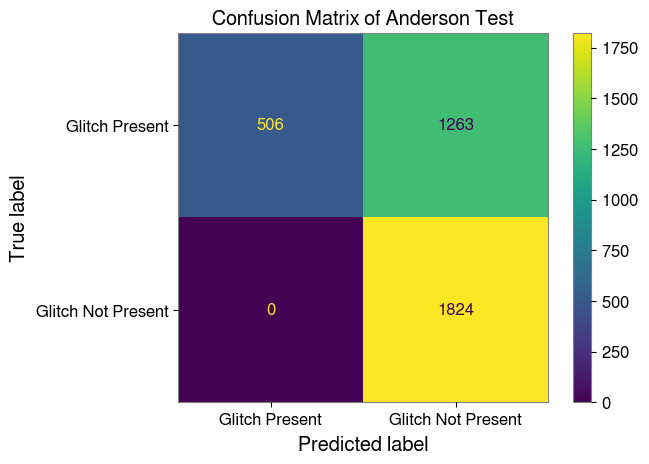

In [32]:
statistical_testing.display_confusion_matrix(bp_combined_df, "Anderson")

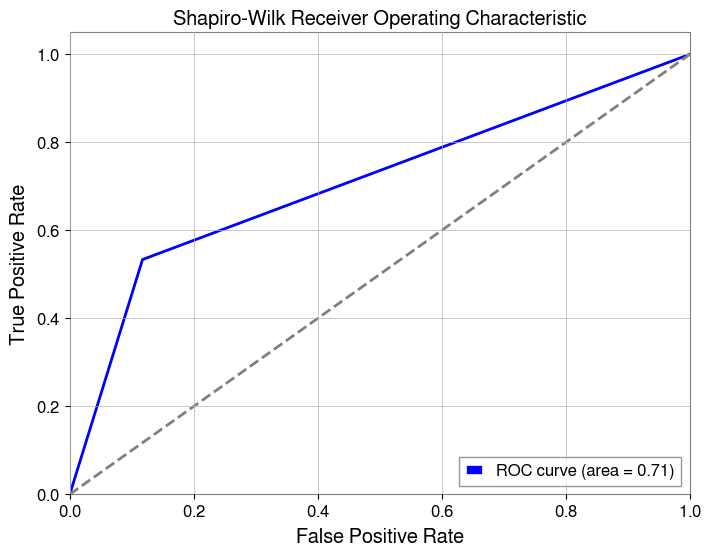

In [33]:
statistical_testing.display_auc_roc(bp_combined_df['glitch_present'], bp_combined_df['shapiro_pvalue'])

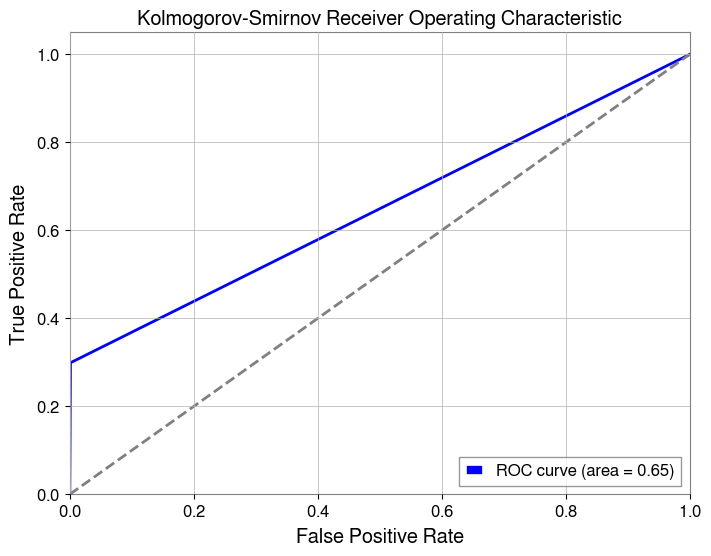

In [34]:
statistical_testing.display_auc_roc(bp_combined_df['glitch_present'], bp_combined_df['ks_pvalue'], "KS")

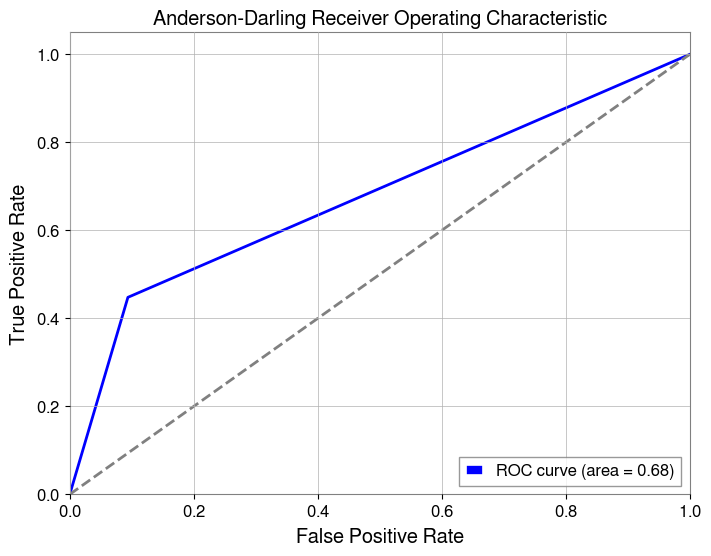

In [35]:
statistical_testing.display_auc_roc(bp_combined_df['glitch_present'], bp_combined_df[['ad_statistic','ad_critical_values']], "Anderson")

In [36]:
generate_glitchwise_confusion_matrices(combined_df)

label shapiro_TP shapiro_FN shapiro_FP shapiro_TN  \
0             1080Lines          4          2          0          0   
1           1400Ripples         72         29          0          0   
2        Air_Compressor          7         94          0          0   
3                  Blip         97          4          0          0   
4    Blip_Low_Frequency         15         86          0          0   
5                 Chirp          2          4          0          0   
6        Extremely_Loud        101          0          0          0   
7       Fast_Scattering          3         98          0          0   
8                 Helix         19          2          0          0   
9              Koi_Fish         99          0          0          0   
10     Light_Modulation         67          5          0          0   
11  Low_Frequency_Burst          8         90          0          0   
12  Low_Frequency_Lines          2         99          0          0   
13         Paired_Doves         43         58          0          0   
14           Power_Line          7         93          0          0   
15      Repeating_Blips         98          3          0          0   
16      Scattered_Light         10         91          0          0   
17             Scratchy          8         37          0          0   
18                Tomte         55         46          0          0   
19          Violin_Mode         86         15          0          0   
20       Wandering_Line          9          0          0          0   
21              Whistle        101          0          0          0   
22         clean_signal          0          0         83       1741   

    shapiro_accuracy  shapiro_recall shapiro_fpr  shapiro_precision  \
0            0.66667         0.66667           0            1.00000   
1            0.71287         0.71287           0            1.00000   
2            0.06931         0.06931           0            1.00000   
3            0.96040         0.96040           0            1.00000   
4            0.14851         0.14851           0            1.00000   
5            0.33333         0.33333           0            1.00000   
6            1.00000         1.00000           0            1.00000   
7            0.02970         0.02970           0            1.00000   
8            0.90476         0.90476           0            1.00000   
9            1.00000         1.00000           0            1.00000   
10           0.93056         0.93056           0            1.00000   
11           0.08163         0.08163           0            1.00000   
12           0.01980         0.01980           0            1.00000   
13           0.42574         0.42574           0            1.00000   
14           0.07000         0.07000           0            1.00000   
15           0.97030         0.97030           0            1.00000   
16           0.09901         0.09901           0            1.00000   
17           0.17778         0.17778           0            1.00000   
18           0.54455         0.54455           0            1.00000   
19           0.85149         0.85149           0            1.00000   
20           1.00000         1.00000           0            1.00000   
21           1.00000         1.00000           0            1.00000   
22           0.95450         0.00000     0.04550            0.00000   

    shapiro_f1_score KS_TP KS_FN KS_FP KS_TN  KS_accuracy  KS_recall  KS_fpr  \
0            0.80000     0     6     0     0      0.00000    0.00000       0   
1            0.83237     0   101     0     0      0.00000    0.00000       0   
2            0.12963     0   101     0     0      0.00000    0.00000       0   
3            0.97980    37    64     0     0      0.36634    0.36634       0   
4            0.25862     2    99     0     0      0.01980    0.01980       0   
5            0.50000     0     6     0     0      0.00000    0.00000       0   
6            1.00000   101     0     0     0    

In [37]:
generate_glitchwise_confusion_matrices(bp_combined_df)

label shapiro_TP shapiro_FN shapiro_FP shapiro_TN  \
0             1080Lines          1          5          0          0   
1           1400Ripples         11         90          0          0   
2        Air_Compressor         10         91          0          0   
3                  Blip        101          0          0          0   
4    Blip_Low_Frequency         38         63          0          0   
5                 Chirp          4          2          0          0   
6        Extremely_Loud        101          0          0          0   
7       Fast_Scattering         12         89          0          0   
8                 Helix         20          1          0          0   
9              Koi_Fish         99          0          0          0   
10     Light_Modulation         70          2          0          0   
11  Low_Frequency_Burst         12         86          0          0   
12  Low_Frequency_Lines         16         85          0          0   
13         Paired_Doves         66         35          0          0   
14           Power_Line         20         80          0          0   
15      Repeating_Blips         98          3          0          0   
16      Scattered_Light         27         74          0          0   
17             Scratchy         25         20          0          0   
18                Tomte         82         19          0          0   
19          Violin_Mode         48         53          0          0   
20       Wandering_Line          8          1          0          0   
21              Whistle         75         26          0          0   
22         clean_signal          0          0        214       1610   

    shapiro_accuracy  shapiro_recall shapiro_fpr  shapiro_precision  \
0            0.16667         0.16667           0            1.00000   
1            0.10891         0.10891           0            1.00000   
2            0.09901         0.09901           0            1.00000   
3            1.00000         1.00000           0            1.00000   
4            0.37624         0.37624           0            1.00000   
5            0.66667         0.66667           0            1.00000   
6            1.00000         1.00000           0            1.00000   
7            0.11881         0.11881           0            1.00000   
8            0.95238         0.95238           0            1.00000   
9            1.00000         1.00000           0            1.00000   
10           0.97222         0.97222           0            1.00000   
11           0.12245         0.12245           0            1.00000   
12           0.15842         0.15842           0            1.00000   
13           0.65347         0.65347           0            1.00000   
14           0.20000         0.20000           0            1.00000   
15           0.97030         0.97030           0            1.00000   
16           0.26733         0.26733           0            1.00000   
17           0.55556         0.55556           0            1.00000   
18           0.81188         0.81188           0            1.00000   
19           0.47525         0.47525           0            1.00000   
20           0.88889         0.88889           0            1.00000   
21           0.74257         0.74257           0            1.00000   
22           0.88268         0.00000     0.11732            0.00000   

    shapiro_f1_score KS_TP KS_FN KS_FP KS_TN  KS_accuracy  KS_recall  KS_fpr  \
0            0.28571     0     6     0     0      0.00000    0.00000       0   
1            0.19643     0   101     0     0      0.00000    0.00000       0   
2            0.18018     0   101     0     0      0.00000    0.00000       0   
3            1.00000    56    45     0     0      0.55446    0.55446       0   
4            0.54676     3    98     0     0      0.02970    0.02970       0   
5            0.80000     0     6     0     0      0.00000    0.00000       0   
6            1.00000   101     0     0     0    

In [38]:
generate_testwise_confusion_matrix(combined_df)

Test   TP    FN  FP    TN  Accuracy  Recall(TPR/Sensitivity)     FPR  \
0   Shapiro  913   856  83  1741   0.73866                  0.51611 0.04550   
1        KS  491  1278   0  1824   0.64431                  0.27756 0.00000   
2  Anderson  472  1297   0  1824   0.63902                  0.26682 0.00000   

   Precision  F1 Score  
0    0.91667   0.66040  
1    1.00000   0.43451  
2    1.00000   0.42124

In [39]:
generate_testwise_confusion_matrix(bp_combined_df)

Test   TP    FN   FP    TN  Accuracy  Recall(TPR/Sensitivity)     FPR  \
0   Shapiro  944   825  214  1610   0.71083                  0.53363 0.11732   
1        KS  529  1240    2  1822   0.65433                  0.29904 0.00110   
2  Anderson  506  1263    0  1824   0.64848                  0.28604 0.00000   

   Precision  F1 Score  
0    0.81520   0.64503  
1    0.99623   0.46000  
2    1.00000   0.44484

In [40]:
frequency_ranges=[[10, 100], [10, 250], [10, 500], [10, 1000], [250,1000], [500,1000]]

combined_df = create_combined_glitch_clean_df(clean_gpstimes[0:700], sample_glitches_df, n_samples=2000)
display(generate_testwise_confusion_matrix(combined_df))
for low_freq, high_freq in frequency_ranges:
    print(f"Low Frequency: {low_freq}, High Frequency: {high_freq}")
    combined_df = create_combined_glitch_clean_df(clean_gpstimes[0:700], sample_glitches_df, n_samples=2000, bandpass=True, low_freq=low_freq, high_freq=high_freq)
    display(generate_testwise_confusion_matrix(combined_df))
    # statistical_testing.display_auc_roc(combined_df['glitch_present'], combined_df['shapiro_pvalue'])
    # statistical_testing.display_auc_roc(combined_df['glitch_present'], combined_df['ks_pvalue'], "KS")
    # statistical_testing.display_auc_roc(combined_df['glitch_present'], combined_df[['ad_statistic','ad_critical_values']], "Anderson")

Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


Test   TP    FN  FP    TN  Accuracy  Recall(TPR/Sensitivity)     FPR  \
0   Shapiro  913   856  83  1741   0.73866                  0.51611 0.04550   
1        KS  491  1278   0  1824   0.64431                  0.27756 0.00000   
2  Anderson  472  1297   0  1824   0.63902                  0.26682 0.00000   

   Precision  F1 Score  
0    0.91667   0.66040  
1    1.00000   0.43451  
2    1.00000   0.42124

Low Frequency: 10, High Frequency: 100
Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


Test    TP   FN    FP    TN  Accuracy  Recall(TPR/Sensitivity)     FPR  \
0   Shapiro  1767    2  1818     6   0.49346                  0.99887 0.99671   
1        KS  1418  351   907   917   0.64987                  0.80158 0.49726   
2  Anderson  1117  652   294  1530   0.73671                  0.63143 0.16118   

   Precision  F1 Score  
0    0.49289   0.66007  
1    0.60989   0.69272  
2    0.79164   0.70252

Low Frequency: 10, High Frequency: 250
Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


Test    TP    FN    FP    TN  Accuracy  Recall(TPR/Sensitivity)  \
0   Shapiro  1661   108  1550   274   0.53855                  0.93895   
1        KS   947   822   195  1629   0.71695                  0.53533   
2  Anderson   756  1013    15  1809   0.71389                  0.42736   

      FPR  Precision  F1 Score  
0 0.84978    0.51728   0.66707  
1 0.10691    0.82925   0.65064  
2 0.00822    0.98054   0.59528

Low Frequency: 10, High Frequency: 500
Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


Test    TP    FN   FP    TN  Accuracy  Recall(TPR/Sensitivity)     FPR  \
0   Shapiro  1263   506  778  1046   0.64264                  0.71396 0.42654   
1        KS   647  1122   29  1795   0.67965                  0.36574 0.01590   
2  Anderson   596  1173    0  1824   0.67353                  0.33691 0.00000   

   Precision  F1 Score  
0    0.61881   0.66299  
1    0.95710   0.52924  
2    1.00000   0.50402

Low Frequency: 10, High Frequency: 1000
Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


Test   TP    FN   FP    TN  Accuracy  Recall(TPR/Sensitivity)     FPR  \
0   Shapiro  944   825  214  1610   0.71083                  0.53363 0.11732   
1        KS  529  1240    2  1822   0.65433                  0.29904 0.00110   
2  Anderson  506  1263    0  1824   0.64848                  0.28604 0.00000   

   Precision  F1 Score  
0    0.81520   0.64503  
1    0.99623   0.46000  
2    1.00000   0.44484

Low Frequency: 250, High Frequency: 1000
Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


Test   TP    FN   FP    TN  Accuracy  Recall(TPR/Sensitivity)     FPR  \
0   Shapiro  674  1095  120  1704   0.66184                  0.38101 0.06579   
1        KS  340  1429    0  1824   0.60228                  0.19220 0.00000   
2  Anderson  334  1435    0  1824   0.60061                  0.18881 0.00000   

   Precision  F1 Score  
0    0.84887   0.52595  
1    1.00000   0.32243  
2    1.00000   0.31764

Low Frequency: 500, High Frequency: 1000
Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


Test   TP    FN  FP    TN  Accuracy  Recall(TPR/Sensitivity)     FPR  \
0   Shapiro  557  1212  85  1739   0.63902                  0.31487 0.04660   
1        KS  276  1493   0  1824   0.58447                  0.15602 0.00000   
2  Anderson  266  1503   0  1824   0.58169                  0.15037 0.00000   

   Precision  F1 Score  
0    0.86760   0.46205  
1    1.00000   0.26993  
2    1.00000   0.26143

In [41]:
combined_df = create_combined_glitch_clean_df(clean_gpstimes[0:700], sample_glitches_df, n_samples=2000)
display(generate_glitchwise_confusion_matrices(combined_df))
for low_freq, high_freq in frequency_ranges:
    print(f"Low Frequency: {low_freq}, High Frequency: {high_freq}")
    combined_df = create_combined_glitch_clean_df(clean_gpstimes[0:700], sample_glitches_df, n_samples=2000, bandpass=True, low_freq=low_freq, high_freq=high_freq)
    display(generate_glitchwise_confusion_matrices(combined_df))

Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


label shapiro_TP shapiro_FN shapiro_FP shapiro_TN  \
0             1080Lines          4          2          0          0   
1           1400Ripples         72         29          0          0   
2        Air_Compressor          7         94          0          0   
3                  Blip         97          4          0          0   
4    Blip_Low_Frequency         15         86          0          0   
5                 Chirp          2          4          0          0   
6        Extremely_Loud        101          0          0          0   
7       Fast_Scattering          3         98          0          0   
8                 Helix         19          2          0          0   
9              Koi_Fish         99          0          0          0   
10     Light_Modulation         67          5          0          0   
11  Low_Frequency_Burst          8         90          0          0   
12  Low_Frequency_Lines          2         99          0          0   
13         Paired_Doves         43         58          0          0   
14           Power_Line          7         93          0          0   
15      Repeating_Blips         98          3          0          0   
16      Scattered_Light         10         91          0          0   
17             Scratchy          8         37          0          0   
18                Tomte         55         46          0          0   
19          Violin_Mode         86         15          0          0   
20       Wandering_Line          9          0          0          0   
21              Whistle        101          0          0          0   
22         clean_signal          0          0         83       1741   

    shapiro_accuracy  shapiro_recall shapiro_fpr  shapiro_precision  \
0            0.66667         0.66667           0            1.00000   
1            0.71287         0.71287           0            1.00000   
2            0.06931         0.06931           0            1.00000   
3            0.96040         0.96040           0            1.00000   
4            0.14851         0.14851           0            1.00000   
5            0.33333         0.33333           0            1.00000   
6            1.00000         1.00000           0            1.00000   
7            0.02970         0.02970           0            1.00000   
8            0.90476         0.90476           0            1.00000   
9            1.00000         1.00000           0            1.00000   
10           0.93056         0.93056           0            1.00000   
11           0.08163         0.08163           0            1.00000   
12           0.01980         0.01980           0            1.00000   
13           0.42574         0.42574           0            1.00000   
14           0.07000         0.07000           0            1.00000   
15           0.97030         0.97030           0            1.00000   
16           0.09901         0.09901           0            1.00000   
17           0.17778         0.17778           0            1.00000   
18           0.54455         0.54455           0            1.00000   
19           0.85149         0.85149           0            1.00000   
20           1.00000         1.00000           0            1.00000   
21           1.00000         1.00000           0            1.00000   
22           0.95450         0.00000     0.04550            0.00000   

    shapiro_f1_score KS_TP KS_FN KS_FP KS_TN  KS_accuracy  KS_recall  KS_fpr  \
0            0.80000     0     6     0     0      0.00000    0.00000       0   
1            0.83237     0   101     0     0      0.00000    0.00000       0   
2            0.12963     0   101     0     0      0.00000    0.00000       0   
3            0.97980    37    64     0     0      0.36634    0.36634       0   
4            0.25862     2    99     0     0      0.01980    0.01980       0   
5            0.50000     0     6     0     0      0.00000    0.00000       0   
6            1.00000   101     0     0     0    

Low Frequency: 10, High Frequency: 100
Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


label shapiro_TP shapiro_FN shapiro_FP shapiro_TN  \
0             1080Lines          6          0          0          0   
1           1400Ripples        100          1          0          0   
2        Air_Compressor        101          0          0          0   
3                  Blip        101          0          0          0   
4    Blip_Low_Frequency        101          0          0          0   
5                 Chirp          6          0          0          0   
6        Extremely_Loud        101          0          0          0   
7       Fast_Scattering        101          0          0          0   
8                 Helix         21          0          0          0   
9              Koi_Fish         99          0          0          0   
10     Light_Modulation         72          0          0          0   
11  Low_Frequency_Burst         98          0          0          0   
12  Low_Frequency_Lines        101          0          0          0   
13         Paired_Doves        101          0          0          0   
14           Power_Line        100          0          0          0   
15      Repeating_Blips        101          0          0          0   
16      Scattered_Light        101          0          0          0   
17             Scratchy         45          0          0          0   
18                Tomte        101          0          0          0   
19          Violin_Mode        100          1          0          0   
20       Wandering_Line          9          0          0          0   
21              Whistle        101          0          0          0   
22         clean_signal          0          0       1818          6   

    shapiro_accuracy  shapiro_recall shapiro_fpr  shapiro_precision  \
0            1.00000         1.00000           0            1.00000   
1            0.99010         0.99010           0            1.00000   
2            1.00000         1.00000           0            1.00000   
3            1.00000         1.00000           0            1.00000   
4            1.00000         1.00000           0            1.00000   
5            1.00000         1.00000           0            1.00000   
6            1.00000         1.00000           0            1.00000   
7            1.00000         1.00000           0            1.00000   
8            1.00000         1.00000           0            1.00000   
9            1.00000         1.00000           0            1.00000   
10           1.00000         1.00000           0            1.00000   
11           1.00000         1.00000           0            1.00000   
12           1.00000         1.00000           0            1.00000   
13           1.00000         1.00000           0            1.00000   
14           1.00000         1.00000           0            1.00000   
15           1.00000         1.00000           0            1.00000   
16           1.00000         1.00000           0            1.00000   
17           1.00000         1.00000           0            1.00000   
18           1.00000         1.00000           0            1.00000   
19           0.99010         0.99010           0            1.00000   
20           1.00000         1.00000           0            1.00000   
21           1.00000         1.00000           0            1.00000   
22           0.00329         0.00000     0.99671            0.00000   

    shapiro_f1_score KS_TP KS_FN KS_FP KS_TN  KS_accuracy  KS_recall  KS_fpr  \
0            1.00000     3     3     0     0      0.50000    0.50000       0   
1            0.99502    57    44     0     0      0.56436    0.56436       0   
2            1.00000    58    43     0     0      0.57426    0.57426       0   
3            1.00000    93     8     0     0      0.92079    0.92079       0   
4            1.00000   100     1     0     0      0.99010    0.99010       0   
5            1.00000     6     0     0     0      1.00000    1.00000       0   
6            1.00000   101     0     0     0    

Low Frequency: 10, High Frequency: 250
Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


label shapiro_TP shapiro_FN shapiro_FP shapiro_TN  \
0             1080Lines          5          1          0          0   
1           1400Ripples         89         12          0          0   
2        Air_Compressor         88         13          0          0   
3                  Blip        101          0          0          0   
4    Blip_Low_Frequency        101          0          0          0   
5                 Chirp          6          0          0          0   
6        Extremely_Loud        101          0          0          0   
7       Fast_Scattering         89         12          0          0   
8                 Helix         21          0          0          0   
9              Koi_Fish         99          0          0          0   
10     Light_Modulation         72          0          0          0   
11  Low_Frequency_Burst         88         10          0          0   
12  Low_Frequency_Lines         88         13          0          0   
13         Paired_Doves        100          1          0          0   
14           Power_Line         94          6          0          0   
15      Repeating_Blips        101          0          0          0   
16      Scattered_Light         88         13          0          0   
17             Scratchy         44          1          0          0   
18                Tomte        101          0          0          0   
19          Violin_Mode         85         16          0          0   
20       Wandering_Line          9          0          0          0   
21              Whistle         91         10          0          0   
22         clean_signal          0          0       1550        274   

    shapiro_accuracy  shapiro_recall shapiro_fpr  shapiro_precision  \
0            0.83333         0.83333           0            1.00000   
1            0.88119         0.88119           0            1.00000   
2            0.87129         0.87129           0            1.00000   
3            1.00000         1.00000           0            1.00000   
4            1.00000         1.00000           0            1.00000   
5            1.00000         1.00000           0            1.00000   
6            1.00000         1.00000           0            1.00000   
7            0.88119         0.88119           0            1.00000   
8            1.00000         1.00000           0            1.00000   
9            1.00000         1.00000           0            1.00000   
10           1.00000         1.00000           0            1.00000   
11           0.89796         0.89796           0            1.00000   
12           0.87129         0.87129           0            1.00000   
13           0.99010         0.99010           0            1.00000   
14           0.94000         0.94000           0            1.00000   
15           1.00000         1.00000           0            1.00000   
16           0.87129         0.87129           0            1.00000   
17           0.97778         0.97778           0            1.00000   
18           1.00000         1.00000           0            1.00000   
19           0.84158         0.84158           0            1.00000   
20           1.00000         1.00000           0            1.00000   
21           0.90099         0.90099           0            1.00000   
22           0.15022         0.00000     0.84978            0.00000   

    shapiro_f1_score KS_TP KS_FN KS_FP KS_TN  KS_accuracy  KS_recall  KS_fpr  \
0            0.90909     1     5     0     0      0.16667    0.16667       0   
1            0.93684    12    89     0     0      0.11881    0.11881       0   
2            0.93122    20    81     0     0      0.19802    0.19802       0   
3            1.00000    94     7     0     0      0.93069    0.93069       0   
4            1.00000    55    46     0     0      0.54455    0.54455       0   
5            1.00000     4     2     0     0      0.66667    0.66667       0   
6            1.00000   101     0     0     0    

Low Frequency: 10, High Frequency: 500
Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


label shapiro_TP shapiro_FN shapiro_FP shapiro_TN  \
0             1080Lines          4          2          0          0   
1           1400Ripples         41         60          0          0   
2        Air_Compressor         54         47          0          0   
3                  Blip        101          0          0          0   
4    Blip_Low_Frequency         77         24          0          0   
5                 Chirp          5          1          0          0   
6        Extremely_Loud        101          0          0          0   
7       Fast_Scattering         42         59          0          0   
8                 Helix         20          1          0          0   
9              Koi_Fish         99          0          0          0   
10     Light_Modulation         71          1          0          0   
11  Low_Frequency_Burst         45         53          0          0   
12  Low_Frequency_Lines         58         43          0          0   
13         Paired_Doves         84         17          0          0   
14           Power_Line         68         32          0          0   
15      Repeating_Blips         98          3          0          0   
16      Scattered_Light         68         33          0          0   
17             Scratchy         34         11          0          0   
18                Tomte         97          4          0          0   
19          Violin_Mode         46         55          0          0   
20       Wandering_Line          3          6          0          0   
21              Whistle         47         54          0          0   
22         clean_signal          0          0        778       1046   

    shapiro_accuracy  shapiro_recall shapiro_fpr  shapiro_precision  \
0            0.66667         0.66667           0            1.00000   
1            0.40594         0.40594           0            1.00000   
2            0.53465         0.53465           0            1.00000   
3            1.00000         1.00000           0            1.00000   
4            0.76238         0.76238           0            1.00000   
5            0.83333         0.83333           0            1.00000   
6            1.00000         1.00000           0            1.00000   
7            0.41584         0.41584           0            1.00000   
8            0.95238         0.95238           0            1.00000   
9            1.00000         1.00000           0            1.00000   
10           0.98611         0.98611           0            1.00000   
11           0.45918         0.45918           0            1.00000   
12           0.57426         0.57426           0            1.00000   
13           0.83168         0.83168           0            1.00000   
14           0.68000         0.68000           0            1.00000   
15           0.97030         0.97030           0            1.00000   
16           0.67327         0.67327           0            1.00000   
17           0.75556         0.75556           0            1.00000   
18           0.96040         0.96040           0            1.00000   
19           0.45545         0.45545           0            1.00000   
20           0.33333         0.33333           0            1.00000   
21           0.46535         0.46535           0            1.00000   
22           0.57346         0.00000     0.42654            0.00000   

    shapiro_f1_score KS_TP KS_FN KS_FP KS_TN  KS_accuracy  KS_recall  KS_fpr  \
0            0.80000     0     6     0     0      0.00000    0.00000       0   
1            0.57746     0   101     0     0      0.00000    0.00000       0   
2            0.69677     0   101     0     0      0.00000    0.00000       0   
3            1.00000    79    22     0     0      0.78218    0.78218       0   
4            0.86517    15    86     0     0      0.14851    0.14851       0   
5            0.90909     3     3     0     0      0.50000    0.50000       0   
6            1.00000   101     0     0     0    

Low Frequency: 10, High Frequency: 1000
Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


label shapiro_TP shapiro_FN shapiro_FP shapiro_TN  \
0             1080Lines          1          5          0          0   
1           1400Ripples         11         90          0          0   
2        Air_Compressor         10         91          0          0   
3                  Blip        101          0          0          0   
4    Blip_Low_Frequency         38         63          0          0   
5                 Chirp          4          2          0          0   
6        Extremely_Loud        101          0          0          0   
7       Fast_Scattering         12         89          0          0   
8                 Helix         20          1          0          0   
9              Koi_Fish         99          0          0          0   
10     Light_Modulation         70          2          0          0   
11  Low_Frequency_Burst         12         86          0          0   
12  Low_Frequency_Lines         16         85          0          0   
13         Paired_Doves         66         35          0          0   
14           Power_Line         20         80          0          0   
15      Repeating_Blips         98          3          0          0   
16      Scattered_Light         27         74          0          0   
17             Scratchy         25         20          0          0   
18                Tomte         82         19          0          0   
19          Violin_Mode         48         53          0          0   
20       Wandering_Line          8          1          0          0   
21              Whistle         75         26          0          0   
22         clean_signal          0          0        214       1610   

    shapiro_accuracy  shapiro_recall shapiro_fpr  shapiro_precision  \
0            0.16667         0.16667           0            1.00000   
1            0.10891         0.10891           0            1.00000   
2            0.09901         0.09901           0            1.00000   
3            1.00000         1.00000           0            1.00000   
4            0.37624         0.37624           0            1.00000   
5            0.66667         0.66667           0            1.00000   
6            1.00000         1.00000           0            1.00000   
7            0.11881         0.11881           0            1.00000   
8            0.95238         0.95238           0            1.00000   
9            1.00000         1.00000           0            1.00000   
10           0.97222         0.97222           0            1.00000   
11           0.12245         0.12245           0            1.00000   
12           0.15842         0.15842           0            1.00000   
13           0.65347         0.65347           0            1.00000   
14           0.20000         0.20000           0            1.00000   
15           0.97030         0.97030           0            1.00000   
16           0.26733         0.26733           0            1.00000   
17           0.55556         0.55556           0            1.00000   
18           0.81188         0.81188           0            1.00000   
19           0.47525         0.47525           0            1.00000   
20           0.88889         0.88889           0            1.00000   
21           0.74257         0.74257           0            1.00000   
22           0.88268         0.00000     0.11732            0.00000   

    shapiro_f1_score KS_TP KS_FN KS_FP KS_TN  KS_accuracy  KS_recall  KS_fpr  \
0            0.28571     0     6     0     0      0.00000    0.00000       0   
1            0.19643     0   101     0     0      0.00000    0.00000       0   
2            0.18018     0   101     0     0      0.00000    0.00000       0   
3            1.00000    56    45     0     0      0.55446    0.55446       0   
4            0.54676     3    98     0     0      0.02970    0.02970       0   
5            0.80000     0     6     0     0      0.00000    0.00000       0   
6            1.00000   101     0     0     0    

Low Frequency: 250, High Frequency: 1000
Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


label shapiro_TP shapiro_FN shapiro_FP shapiro_TN  \
0             1080Lines          3          3          0          0   
1           1400Ripples          8         93          0          0   
2        Air_Compressor          6         95          0          0   
3                  Blip         86         15          0          0   
4    Blip_Low_Frequency         10         91          0          0   
5                 Chirp          1          5          0          0   
6        Extremely_Loud        100          1          0          0   
7       Fast_Scattering         13         88          0          0   
8                 Helix         14          7          0          0   
9              Koi_Fish         97          2          0          0   
10     Light_Modulation         66          6          0          0   
11  Low_Frequency_Burst          5         93          0          0   
12  Low_Frequency_Lines         10         91          0          0   
13         Paired_Doves         16         85          0          0   
14           Power_Line          8         92          0          0   
15      Repeating_Blips         83         18          0          0   
16      Scattered_Light          3         98          0          0   
17             Scratchy          7         38          0          0   
18                Tomte          4         97          0          0   
19          Violin_Mode         50         51          0          0   
20       Wandering_Line          9          0          0          0   
21              Whistle         75         26          0          0   
22         clean_signal          0          0        120       1704   

    shapiro_accuracy  shapiro_recall shapiro_fpr  shapiro_precision  \
0            0.50000         0.50000           0            1.00000   
1            0.07921         0.07921           0            1.00000   
2            0.05941         0.05941           0            1.00000   
3            0.85149         0.85149           0            1.00000   
4            0.09901         0.09901           0            1.00000   
5            0.16667         0.16667           0            1.00000   
6            0.99010         0.99010           0            1.00000   
7            0.12871         0.12871           0            1.00000   
8            0.66667         0.66667           0            1.00000   
9            0.97980         0.97980           0            1.00000   
10           0.91667         0.91667           0            1.00000   
11           0.05102         0.05102           0            1.00000   
12           0.09901         0.09901           0            1.00000   
13           0.15842         0.15842           0            1.00000   
14           0.08000         0.08000           0            1.00000   
15           0.82178         0.82178           0            1.00000   
16           0.02970         0.02970           0            1.00000   
17           0.15556         0.15556           0            1.00000   
18           0.03960         0.03960           0            1.00000   
19           0.49505         0.49505           0            1.00000   
20           1.00000         1.00000           0            1.00000   
21           0.74257         0.74257           0            1.00000   
22           0.93421         0.00000     0.06579            0.00000   

    shapiro_f1_score KS_TP KS_FN KS_FP KS_TN  KS_accuracy  KS_recall  KS_fpr  \
0            0.66667     0     6     0     0      0.00000    0.00000       0   
1            0.14679     0   101     0     0      0.00000    0.00000       0   
2            0.11215     0   101     0     0      0.00000    0.00000       0   
3            0.91979    34    67     0     0      0.33663    0.33663       0   
4            0.18018     2    99     0     0      0.01980    0.01980       0   
5            0.28571     0     6     0     0      0.00000    0.00000       0   
6            0.99502   100     1     0     0    

Low Frequency: 500, High Frequency: 1000
Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


label shapiro_TP shapiro_FN shapiro_FP shapiro_TN  \
0             1080Lines          2          4          0          0   
1           1400Ripples          5         96          0          0   
2        Air_Compressor          4         97          0          0   
3                  Blip         47         54          0          0   
4    Blip_Low_Frequency          8         93          0          0   
5                 Chirp          1          5          0          0   
6        Extremely_Loud        100          1          0          0   
7       Fast_Scattering          3         98          0          0   
8                 Helix         10         11          0          0   
9              Koi_Fish         82         17          0          0   
10     Light_Modulation         54         18          0          0   
11  Low_Frequency_Burst          8         90          0          0   
12  Low_Frequency_Lines          6         95          0          0   
13         Paired_Doves          7         94          0          0   
14           Power_Line          6         94          0          0   
15      Repeating_Blips         57         44          0          0   
16      Scattered_Light          5         96          0          0   
17             Scratchy          4         41          0          0   
18                Tomte          4         97          0          0   
19          Violin_Mode         57         44          0          0   
20       Wandering_Line          9          0          0          0   
21              Whistle         78         23          0          0   
22         clean_signal          0          0         85       1739   

    shapiro_accuracy  shapiro_recall shapiro_fpr  shapiro_precision  \
0            0.33333         0.33333           0            1.00000   
1            0.04950         0.04950           0            1.00000   
2            0.03960         0.03960           0            1.00000   
3            0.46535         0.46535           0            1.00000   
4            0.07921         0.07921           0            1.00000   
5            0.16667         0.16667           0            1.00000   
6            0.99010         0.99010           0            1.00000   
7            0.02970         0.02970           0            1.00000   
8            0.47619         0.47619           0            1.00000   
9            0.82828         0.82828           0            1.00000   
10           0.75000         0.75000           0            1.00000   
11           0.08163         0.08163           0            1.00000   
12           0.05941         0.05941           0            1.00000   
13           0.06931         0.06931           0            1.00000   
14           0.06000         0.06000           0            1.00000   
15           0.56436         0.56436           0            1.00000   
16           0.04950         0.04950           0            1.00000   
17           0.08889         0.08889           0            1.00000   
18           0.03960         0.03960           0            1.00000   
19           0.56436         0.56436           0            1.00000   
20           1.00000         1.00000           0            1.00000   
21           0.77228         0.77228           0            1.00000   
22           0.95340         0.00000     0.04660            0.00000   

    shapiro_f1_score KS_TP KS_FN KS_FP KS_TN  KS_accuracy  KS_recall  KS_fpr  \
0            0.50000     0     6     0     0      0.00000    0.00000       0   
1            0.09434     0   101     0     0      0.00000    0.00000       0   
2            0.07619     0   101     0     0      0.00000    0.00000       0   
3            0.63514    21    80     0     0      0.20792    0.20792       0   
4            0.14679     0   101     0     0      0.00000    0.00000       0   
5            0.28571     0     6     0     0      0.00000    0.00000       0   
6            0.99502    97     4     0     0    

In [42]:
combined_df = create_combined_glitch_clean_df(clean_gpstimes[0:700], sample_glitches_df, n_samples=2000, bandpass=True, low_freq=1000, high_freq=1100)
display(generate_glitchwise_confusion_matrices(combined_df))

Input Length:  700


Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


label shapiro_TP shapiro_FN shapiro_FP shapiro_TN  \
0             1080Lines          5          1          0          0   
1           1400Ripples         55         46          0          0   
2        Air_Compressor         63         38          0          0   
3                  Blip         71         30          0          0   
4    Blip_Low_Frequency         50         51          0          0   
5                 Chirp          3          3          0          0   
6        Extremely_Loud        100          1          0          0   
7       Fast_Scattering         54         47          0          0   
8                 Helix         13          8          0          0   
9              Koi_Fish         81         18          0          0   
10     Light_Modulation         56         16          0          0   
11  Low_Frequency_Burst         45         53          0          0   
12  Low_Frequency_Lines         50         51          0          0   
13         Paired_Doves         52         49          0          0   
14           Power_Line         44         56          0          0   
15      Repeating_Blips         70         31          0          0   
16      Scattered_Light         64         37          0          0   
17             Scratchy         33         12          0          0   
18                Tomte         61         40          0          0   
19          Violin_Mode         81         20          0          0   
20       Wandering_Line          7          2          0          0   
21              Whistle         95          6          0          0   
22         clean_signal          0          0        977        847   

    shapiro_accuracy  shapiro_recall shapiro_fpr  shapiro_precision  \
0            0.83333         0.83333           0            1.00000   
1            0.54455         0.54455           0            1.00000   
2            0.62376         0.62376           0            1.00000   
3            0.70297         0.70297           0            1.00000   
4            0.49505         0.49505           0            1.00000   
5            0.50000         0.50000           0            1.00000   
6            0.99010         0.99010           0            1.00000   
7            0.53465         0.53465           0            1.00000   
8            0.61905         0.61905           0            1.00000   
9            0.81818         0.81818           0            1.00000   
10           0.77778         0.77778           0            1.00000   
11           0.45918         0.45918           0            1.00000   
12           0.49505         0.49505           0            1.00000   
13           0.51485         0.51485           0            1.00000   
14           0.44000         0.44000           0            1.00000   
15           0.69307         0.69307           0            1.00000   
16           0.63366         0.63366           0            1.00000   
17           0.73333         0.73333           0            1.00000   
18           0.60396         0.60396           0            1.00000   
19           0.80198         0.80198           0            1.00000   
20           0.77778         0.77778           0            1.00000   
21           0.94059         0.94059           0            1.00000   
22           0.46436         0.00000     0.53564            0.00000   

    shapiro_f1_score KS_TP KS_FN KS_FP KS_TN  KS_accuracy  KS_recall  KS_fpr  \
0            0.90909     3     3     0     0      0.50000    0.50000       0   
1            0.70513     5    96     0     0      0.04950    0.04950       0   
2            0.76829     5    96     0     0      0.04950    0.04950       0   
3            0.82558    18    83     0     0      0.17822    0.17822       0   
4            0.66225     4    97     0     0      0.03960    0.03960       0   
5            0.66667     0     6     0     0      0.00000    0.00000       0   
6            0.99502    89    12     0     0    

<class 'int'> <class 'int'> <class 'int'>
Time elapsed for q-transform: 0.18 seconds


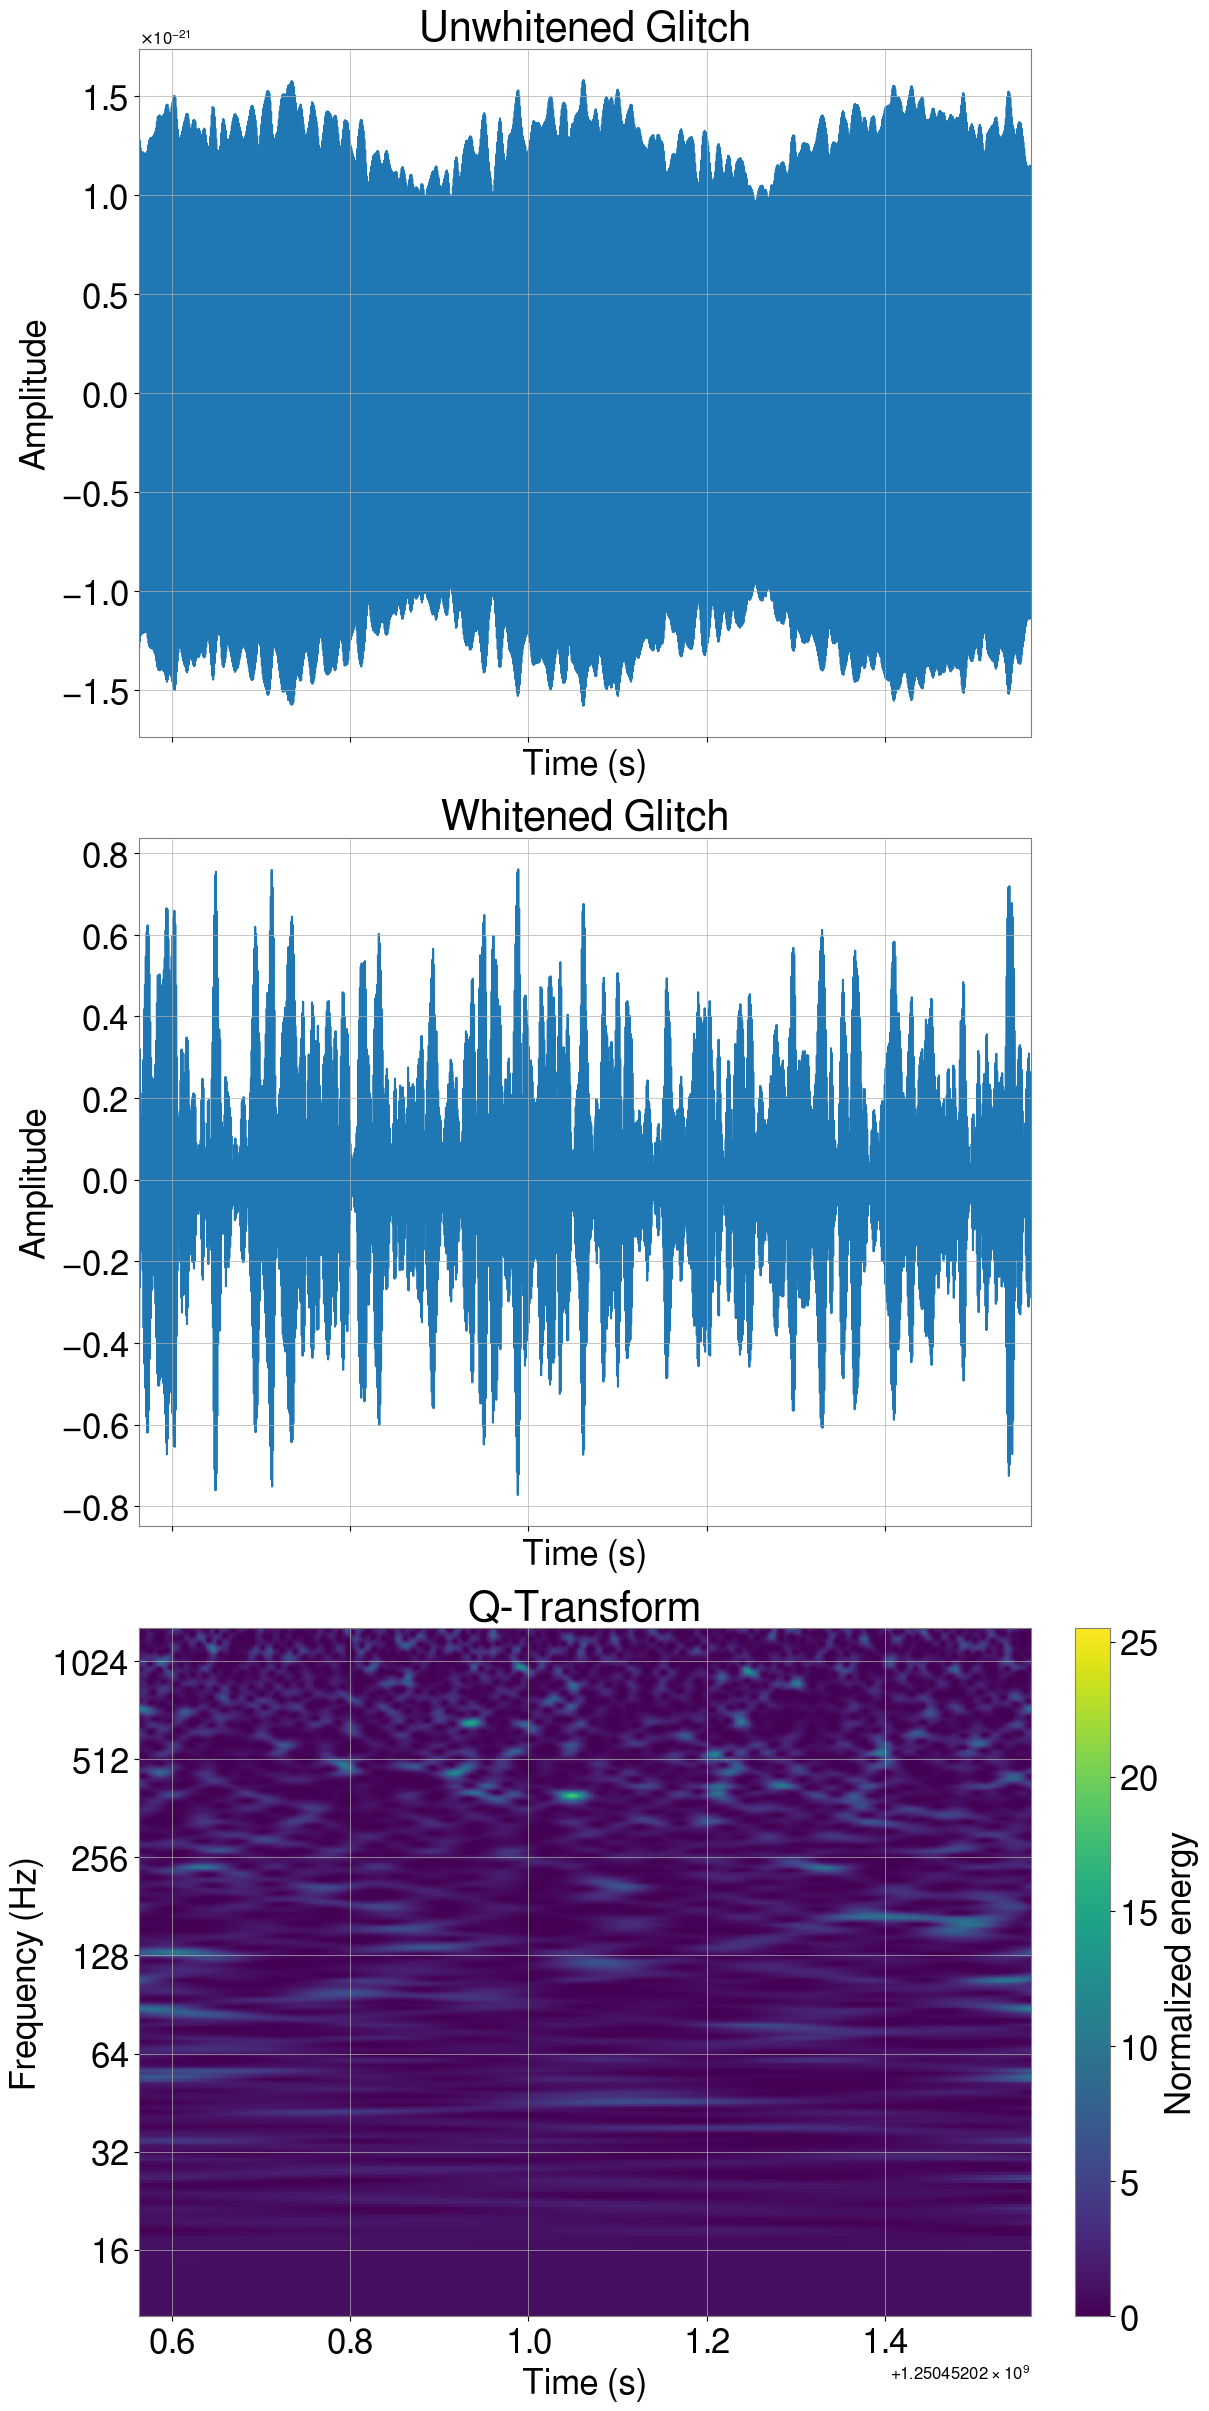

In [43]:
statistical_testing.display_sample_plots(combined_df[combined_df['label'] == 'Scattered_Light'].sample(1).iloc[0])

# Experimenting with the Fractal Dimension

The fractal dimension is another way for us to visualize and characterize our data. FD characterizes the self similarity of a set and provides a measure of complexity of the signal in terms of signal processing. Basically, it tells us how complex a shape is, which in this case would be the shape of the time series signal. If we were to use this in the context of time series signals, it would be as a **Variation over Time** telling us how complex the signal is. Glitches cause this FD value to change.

For this we use the VAR method. (Referenced from LIGO repositories)

In [20]:
combined_df = create_combined_glitch_clean_df(clean_gpstimes[0:700], sample_glitches_df, n_samples=2000)
# combined_df = create_combined_glitch_clean_df(clean_gpstimes[0:700], sample_glitches_df, observation_tw=5, n_samples=2000)

Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present', 'snr'],
      dtype='object')
Index(['GPStime', 'snr', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


In [21]:
combined_df.shape

(3593, 17)

In [90]:
# Tomte
example = combined_df.loc[combined_df['label'] == 'Tomte'].iloc[0]
example_ts = statistical_testing.get_sample_glitch_from_filepath(example["timeseries_file_location"], observation_tw=5)[1]

In [91]:
# Clean Signal
example2 = combined_df.loc[combined_df['label'] == 'clean_signal'].iloc[1]

example_ts2 = TimeSeries.read(example2["timeseries_file_location"])
example_ts2 = example_ts2.whiten(4,2)
example_ts2 = example_ts2[int(4096):int(20480)]

asd = example_ts2.asd()

In [92]:
# Scattered Light
example3 = combined_df.loc[combined_df['label'] == 'Scattered_Light'].iloc[0]
example_ts3 = statistical_testing.get_sample_glitch_from_filepath(example3["timeseries_file_location"], observation_tw=5)[1]

In [93]:
example["timeseries_file_location"]

'./timeseries_data/sample_L1_1248235640.34_white10.h5'

In [94]:
example_ts.shape

(20480,)

In [95]:
np.arange(0, 4096//(2*64))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,
       14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
       28, 29, 30, 31])

In [28]:
import numba

### What's happening here (My understanding of it)

F_k contains all the fractional dimensions being calculated for the given TimeSeries signal given the decimate value.

To calculate F_k, the outer loop takes values from 1 to half the length of the signal times the deimate, while the inner loop goes from the value of the outer loop to the end of the signal minus the outer loop value. At each iteration of the inner loop a window  of size [k-l, k-l+1] goes along the signal and calculates the absolute value of the difference between the minimum and maximum amplitude values, the mean of which us the A_var values. With each outer iteration the size of this window increases gradually until it goes up to the whole length of the signal.

Second version of FD code (the correct implementation) 

In [29]:
@numba.njit("f4[:](f4[:,:], i8, i8)", parallel=True)
def faster_compute_fractals_var(fs, dec, step):
    FDs = np.empty(shape=fs.shape[0], dtype=np.float32)
    N = fs.shape[1]
    for ii in numba.prange(fs.shape[0]):
        f = fs[ii]
        k_n = np.arange(1, N//(2*dec), step, np.int64)
        n_max = len(k_n)
        V_i = np.empty(shape=(n_max), dtype=np.float32)

        ub = np.empty(shape=(N-2*k_n[0],2), dtype=np.float32) # current iteration
        for i in range(0, N-2*k_n[0]):
            ub[i,0] = np.max(f[i:i+2*k_n[0]+1])
            ub[i,1] = np.min(f[i:i+2*k_n[0]+1])
        V_i[0] = np.mean(ub[:,0]-ub[:,1])

        for n in range(1,n_max):
            d = k_n[n] - k_n[n-1]
            for i in range(0, N-2*k_n[n]):
                ub[i,0] = max(ub[i,0], ub[i+2*d,0])
                ub[i,1] = min(ub[i,1], ub[i+2*d,1])
            V_i[n] = np.mean(ub[:N-2*k_n[n],0]-ub[:N-2*k_n[n],1])

        X = np.log(k_n)
        X_m = X - np.mean(X)
        Y = np.log(V_i)
        Y_m = Y - np.mean(Y)
        FDs[ii] = 2 - np.sum((X_m)*(Y_m))/np.sum((X_m)**2)
    return FDs


In [30]:
def segmentize(data, seg_length, overlap):
    """
    Segment the data into overlapping segments.
    """

    data_strides = data.strides

    num_segs = int((data.shape[1] - overlap)/(seg_length - overlap))
    seg_shape = (data.shape[0], num_segs, seg_length)

    seg_strides = (data_strides[0], data_strides[1]*(seg_length - overlap), data_strides[1])

    segs = np.lib.stride_tricks.as_strided(data, shape=seg_shape, strides=seg_strides)

    return segs
    

In [31]:
# eg_ts2d_chunks = np.split(example_ts.value, 64)

In [32]:
# len(eg_ts2d_chunks)

In [33]:
# eg_fd1 = []
# for chunk in eg_ts2d_chunks:
#     eg_fd1.append(faster_compute_fractals_var(np.array(chunk.reshape(1,-1).astype(np.float32)), dec=8, step=2))

In [96]:
eg_ts2d = example_ts.value.reshape(1,-1).astype(np.float32)

In [97]:
eg_ts2d.shape

(1, 20480)

In [98]:
eg_ts2d_segmented = segmentize(eg_ts2d, 64, 32)

In [99]:
eg_ts2d_segmented.shape

(1, 639, 64)

In [100]:
points_per_seg = eg_ts2d_segmented.shape[1]
eg_ts2d_segmented = eg_ts2d_segmented.reshape(eg_ts2d_segmented.shape[0]*eg_ts2d_segmented.shape[1], eg_ts2d_segmented.shape[2])

In [101]:
eg_ts2d_segmented.shape

(639, 64)

In [102]:
eg_fd1 = faster_compute_fractals_var(eg_ts2d_segmented, dec=2, step=2)

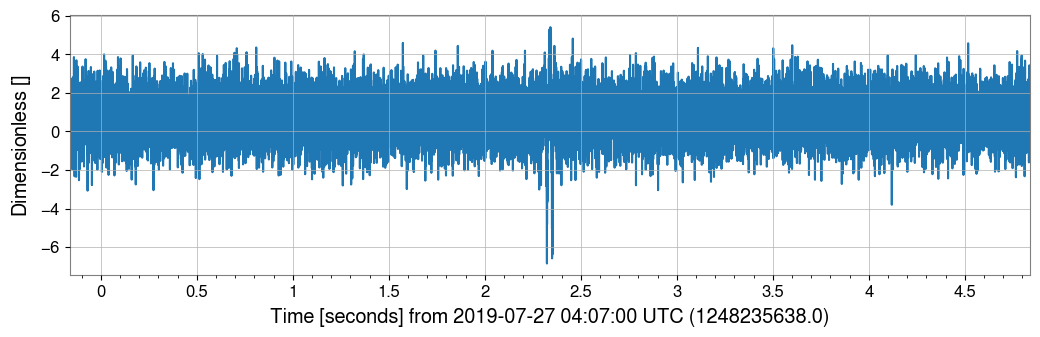

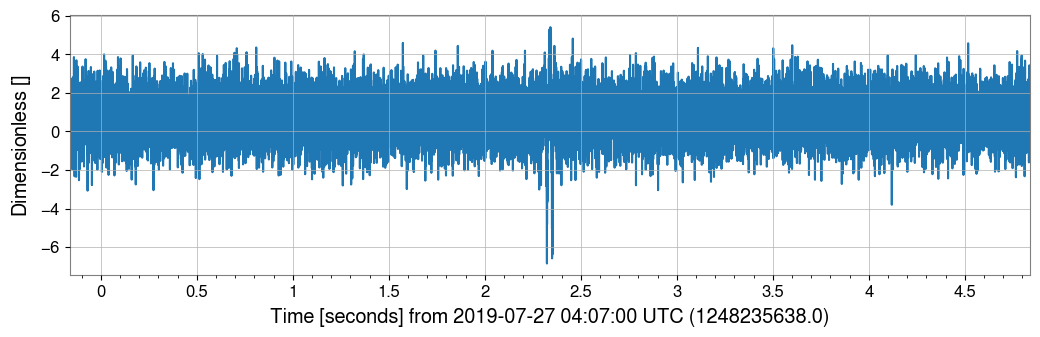

In [103]:
example_ts.plot()

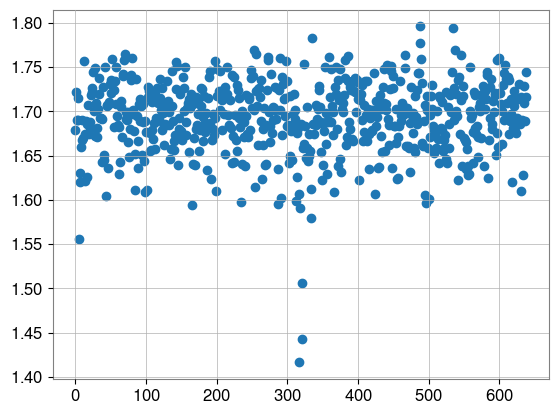

In [104]:
# Tomte
plt.plot(eg_fd1, 'o')

In [105]:
eg_ts2d2 = example_ts2.value.reshape(1,-1).astype(np.float32)
eg_ts2d_segmented2 = segmentize(eg_ts2d2, 64, 32)
points_per_seg = eg_ts2d_segmented2.shape[1]
eg_ts2d_segmented2 = eg_ts2d_segmented2.reshape(eg_ts2d_segmented2.shape[0]*eg_ts2d_segmented2.shape[1], eg_ts2d_segmented2.shape[2])
eg_fd2 = faster_compute_fractals_var(eg_ts2d_segmented2, dec=2, step=2)

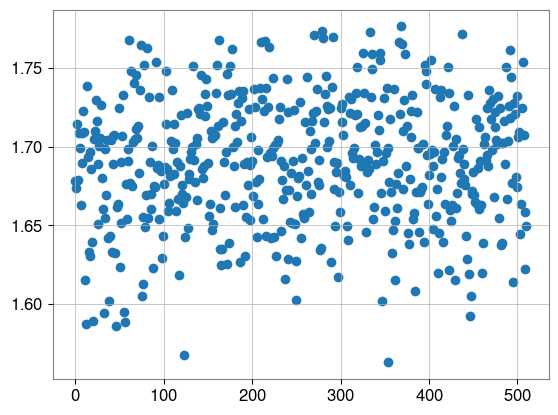

In [106]:
#Clean Signal
plt.plot(eg_fd2, 'o')

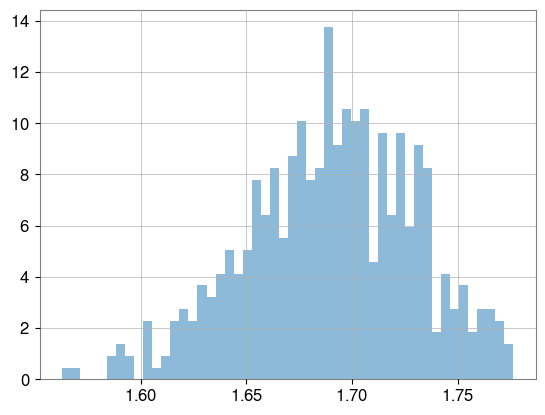

In [107]:
plt.hist(eg_fd2, bins=50, alpha=0.5, label='Scattered Light', density=True)
plt.show()

In [108]:
eg_ts2d3 = example_ts3.value.reshape(1,-1).astype(np.float32)

In [109]:
eg_ts2d3 = example_ts3.value.reshape(1,-1).astype(np.float32)
eg_ts2d_segmented3 = segmentize(eg_ts2d3, 64, 32)
points_per_seg = eg_ts2d_segmented3.shape[1]
eg_ts2d_segmented3 = eg_ts2d_segmented3.reshape(eg_ts2d_segmented3.shape[0]*eg_ts2d_segmented3.shape[1], eg_ts2d_segmented3.shape[2])
eg_fd3 = faster_compute_fractals_var(eg_ts2d_segmented3, dec=2, step=2)

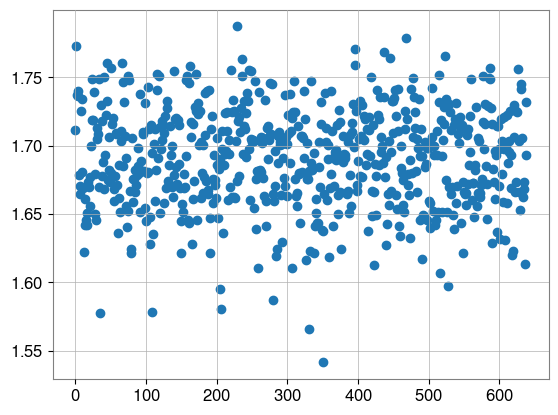

In [110]:
#Scattered Light
plt.plot(eg_fd3, 'o')

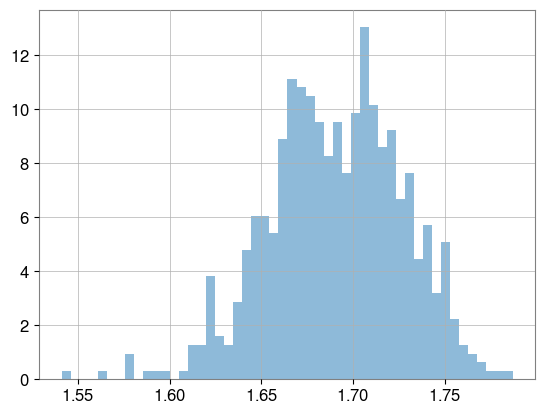

In [111]:
plt.hist(eg_fd3, bins=50, alpha=0.5, label='Scattered Light', density=True)
plt.show()

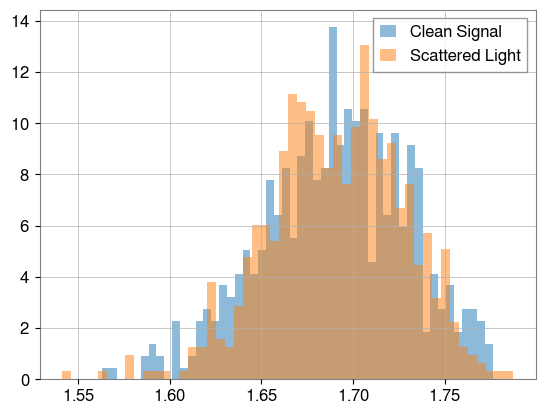

In [112]:
plt.hist(eg_fd2, bins=50, alpha=0.5, label='Clean Signal', density=True)
plt.hist(eg_fd3, bins=50, alpha=0.5, label='Scattered Light', density=True)
plt.legend()
plt.show()

In [113]:
example4 = combined_df.loc[combined_df['label'] == 'Extremely_Loud'].iloc[1]
example_ts4 = statistical_testing.get_sample_glitch_from_filepath(example4["timeseries_file_location"], observation_tw=5)[1]

In [114]:
eg_ts2d4 = example_ts4.value.reshape(1,-1).astype(np.float32)
eg_ts2d_segmented4 = segmentize(eg_ts2d4, 64, 32)
points_per_seg = eg_ts2d_segmented4.shape[1]
eg_ts2d_segmented4 = eg_ts2d_segmented4.reshape(eg_ts2d_segmented4.shape[0]*eg_ts2d_segmented4.shape[1], eg_ts2d_segmented4.shape[2])
eg_fd4 = faster_compute_fractals_var(eg_ts2d_segmented4, dec=2, step=2)

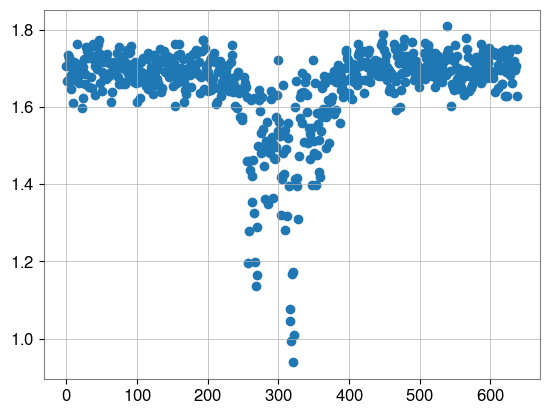

In [115]:
# Extremely Loud
plt.plot(eg_fd4, 'o')

In [116]:
# Clean Signal
example5 = combined_df.loc[combined_df['label'] == 'clean_signal'].iloc[1]

example_ts5 = TimeSeries.read(example5["timeseries_file_location"])
example_ts5 = example_ts5.whiten(4,2)
example_ts5 = example_ts5[int(4096):int(20480)]

asd = example_ts5.asd()

In [117]:
eg_ts2d5 = example_ts2.value.reshape(1,-1).astype(np.float32)
eg_ts2d_segmented5 = segmentize(eg_ts2d5, 64, 32)
points_per_seg = eg_ts2d_segmented5.shape[1]
eg_ts2d_segmented5 = eg_ts2d_segmented5.reshape(eg_ts2d_segmented5.shape[0]*eg_ts2d_segmented5.shape[1], eg_ts2d_segmented5.shape[2])
eg_fd5 = faster_compute_fractals_var(eg_ts2d_segmented5, dec=2, step=2)

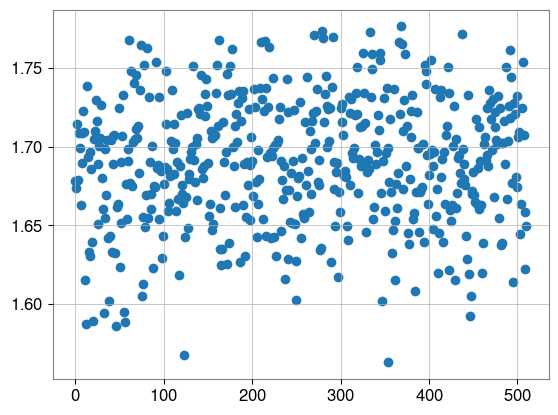

In [118]:
plt.plot(eg_fd5, 'o')

In [119]:
# Blip example
example6 = combined_df.loc[combined_df['label'] == 'Blip'].iloc[5]
example_ts6 = statistical_testing.get_sample_glitch_from_filepath(example6["timeseries_file_location"], observation_tw=5)[1]

eg_ts2d6 = example_ts6.value.reshape(1,-1).astype(np.float32)
eg_ts2d_segmented6 = segmentize(eg_ts2d6, 64, 32)
points_per_seg6 = eg_ts2d_segmented6.shape[1]
eg_ts2d_segmented6 = eg_ts2d_segmented6.reshape(eg_ts2d_segmented6.shape[0]*eg_ts2d_segmented6.shape[1], eg_ts2d_segmented6.shape[2])
eg_fd6 = faster_compute_fractals_var(eg_ts2d_segmented6, dec=2, step=2)

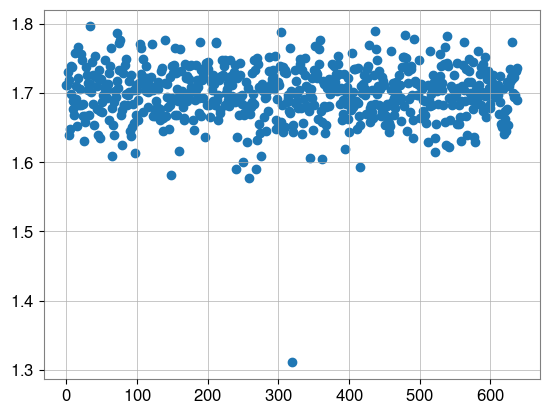

In [120]:
plt.plot(eg_fd6, 'o')

In [121]:
# 1080Lines example
example7 = combined_df.loc[combined_df['label'] == '1080Lines'].iloc[1]
example_ts7 = statistical_testing.get_sample_glitch_from_filepath(example7["timeseries_file_location"], observation_tw=5)[1]

eg_ts2d7 = example_ts7.value.reshape(1,-1).astype(np.float32)
eg_ts2d_segmented7 = segmentize(eg_ts2d7, 64, 32)
points_per_seg7 = eg_ts2d_segmented7.shape[1]
eg_ts2d_segmented7 = eg_ts2d_segmented7.reshape(eg_ts2d_segmented7.shape[0]*eg_ts2d_segmented7.shape[1], eg_ts2d_segmented7.shape[2])
eg_fd7 = faster_compute_fractals_var(eg_ts2d_segmented7, dec=2, step=2)

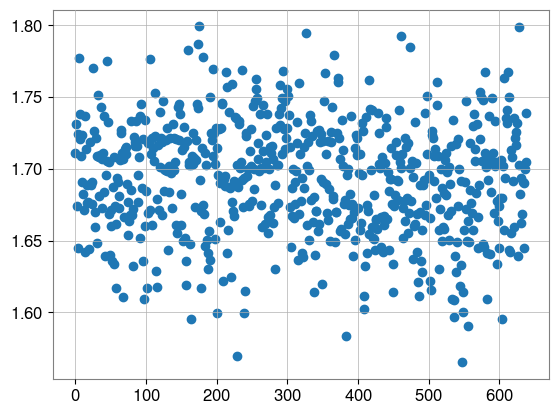

In [122]:
plt.plot(eg_fd7, 'o')

In [123]:
# Chirp example
example8 = combined_df.loc[combined_df['label'] == 'Chirp'].iloc[1]
example_ts8 = statistical_testing.get_sample_glitch_from_filepath(example8["timeseries_file_location"], observation_tw=5)[1]

eg_ts2d8 = example_ts8.value.reshape(1,-1).astype(np.float32)
eg_ts2d_segmented8 = segmentize(eg_ts2d8, 64, 32)
points_per_seg8 = eg_ts2d_segmented8.shape[1]
eg_ts2d_segmented8 = eg_ts2d_segmented8.reshape(eg_ts2d_segmented8.shape[0]*eg_ts2d_segmented8.shape[1], eg_ts2d_segmented8.shape[2])
eg_fd8 = faster_compute_fractals_var(eg_ts2d_segmented8, dec=2, step=2)

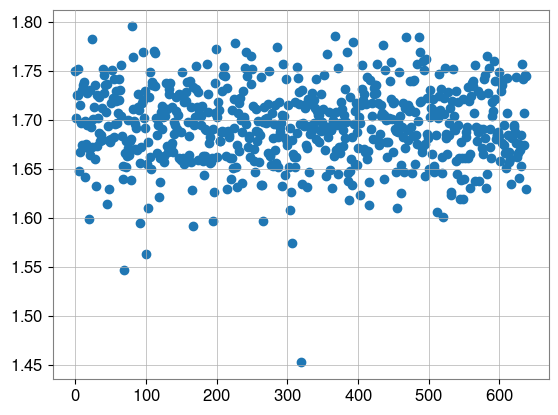

In [124]:
plt.plot(eg_fd8, 'o')

In [125]:
# Koi_Fish example
example9 = combined_df.loc[combined_df['label'] == 'Koi_Fish'].iloc[1]
example_ts9 = statistical_testing.get_sample_glitch_from_filepath(example9["timeseries_file_location"], observation_tw=5)[1]

eg_ts2d9 = example_ts9.value.reshape(1,-1).astype(np.float32)
eg_ts2d_segmented9 = segmentize(eg_ts2d9, 64, 32)
points_per_seg9 = eg_ts2d_segmented9.shape[1]
eg_ts2d_segmented9 = eg_ts2d_segmented9.reshape(eg_ts2d_segmented9.shape[0]*eg_ts2d_segmented9.shape[1], eg_ts2d_segmented9.shape[2])
eg_fd9 = faster_compute_fractals_var(eg_ts2d_segmented9, dec=2, step=2)

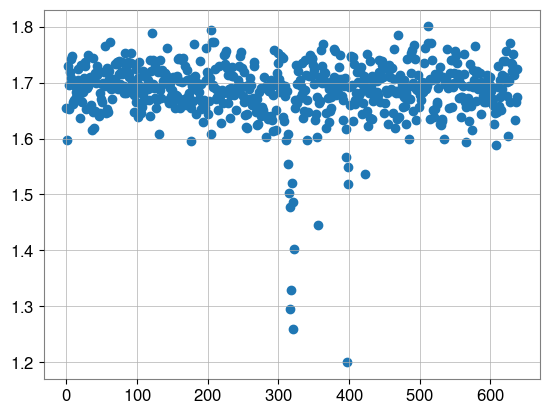

In [126]:
plt.plot(eg_fd9, 'o')

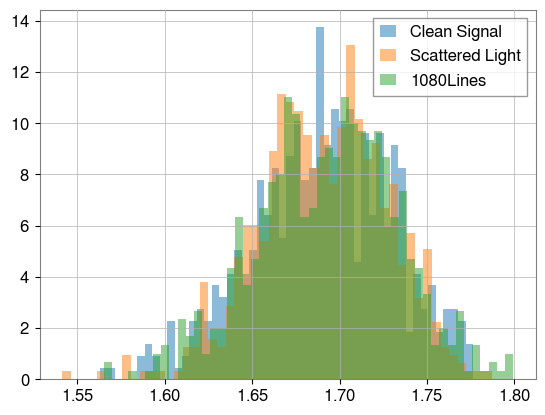

In [129]:
plt.hist(eg_fd2, bins=50, alpha=0.5, label='Clean Signal', density=True)
plt.hist(eg_fd3, bins=50, alpha=0.5, label='Scattered Light', density=True)
# plt.hist(eg_fd1, bins=50, alpha=0.5, label='Tomte', density=True)
plt.hist(eg_fd7, bins=50, alpha=0.5, label='1080Lines', density=True)
# plt.hist(eg_fd6, bins=50, alpha=0.5, label='Blip', density=True)
# plt.hist(eg_fd4, bins=50, alpha=0.5, label='Extremely Loud', density=True)
plt.legend()
plt.show()

In [ ]:
for i in range(10):
    avg_example_clean = combined_df.loc[combined_df['label'] == 'clean_signal'].iloc[2]
    example_ts5 = TimeSeries.read(example5["timeseries_file_location"])
    example_ts5 = example_ts5.whiten(4,2)
    example_ts5 = example_ts5[int(4096):int(20480)]

### Studying the FFTs of the signals

In [66]:
from scipy import signal

eg_fft = example_ts.fft()
eg_fft2 = example_ts2.fft()
eg_fft3 = example_ts3.fft()

f1, t1, Zxx1 = signal.stft(example_ts, fs=4096, nperseg=32, noverlap=16)
f2, t2, Zxx2 = signal.stft(example_ts2, fs=4096, nperseg=32, noverlap=16)
f3, t3, Zxx3 = signal.stft(example_ts3, fs=4096, nperseg=32, noverlap=16)

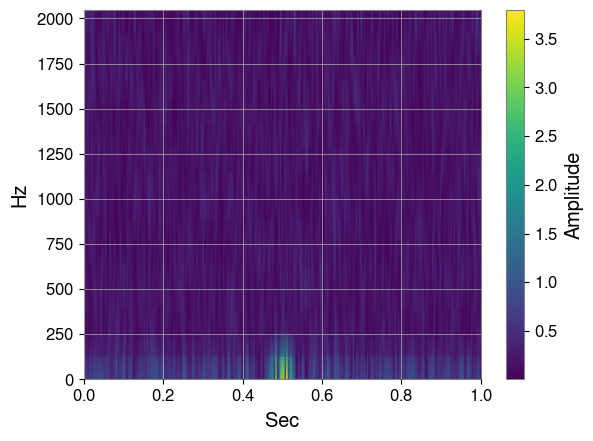

In [67]:
# Tomte
plt.pcolormesh(t1, f1, np.abs(Zxx1), shading='gouraud')
plt.ylabel('Hz')
plt.xlabel('Sec')
plt.colorbar(label='Amplitude')
plt.show()

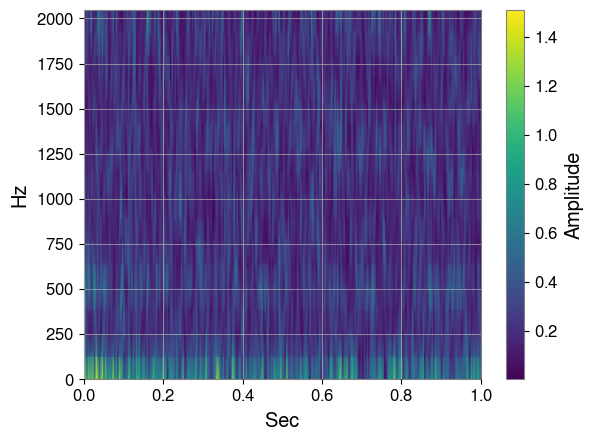

In [68]:
# Clean Signal
plt.pcolormesh(t2, f2, np.abs(Zxx2), shading='gouraud')
plt.ylabel('Hz')
plt.xlabel('Sec')
plt.colorbar(label='Amplitude')
plt.show()

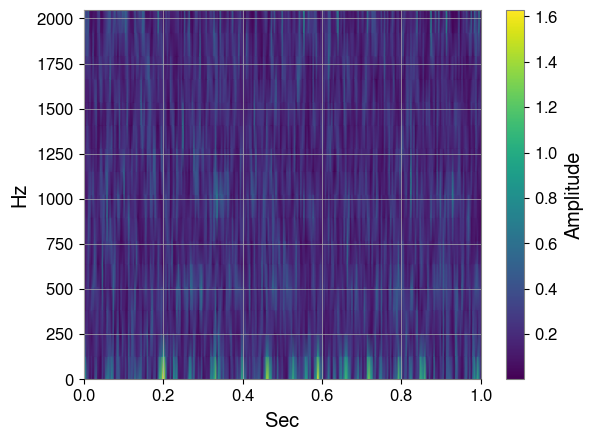

In [69]:
# Scattered Light
plt.pcolormesh(t3, f3, np.abs(Zxx3), shading='gouraud')
plt.ylabel('Hz')
plt.xlabel('Sec')
plt.colorbar(label='Amplitude')
plt.show()

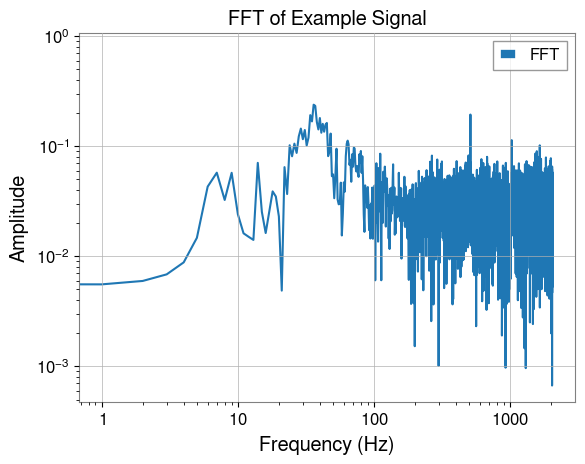

In [70]:
# Tomte
plt.plot(eg_fft.frequencies, np.abs(eg_fft.value), label="FFT")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("FFT of Example Signal")
plt.legend()
plt.show()

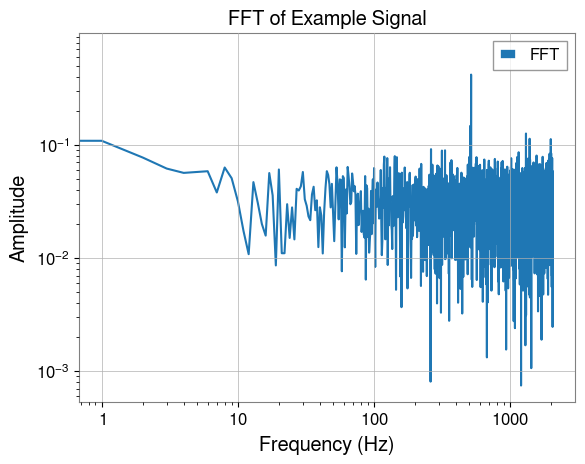

In [71]:
# Clean Data
plt.plot(eg_fft2.frequencies, np.abs(eg_fft2.value), label="FFT")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("FFT of Example Signal")
plt.legend()
plt.show()

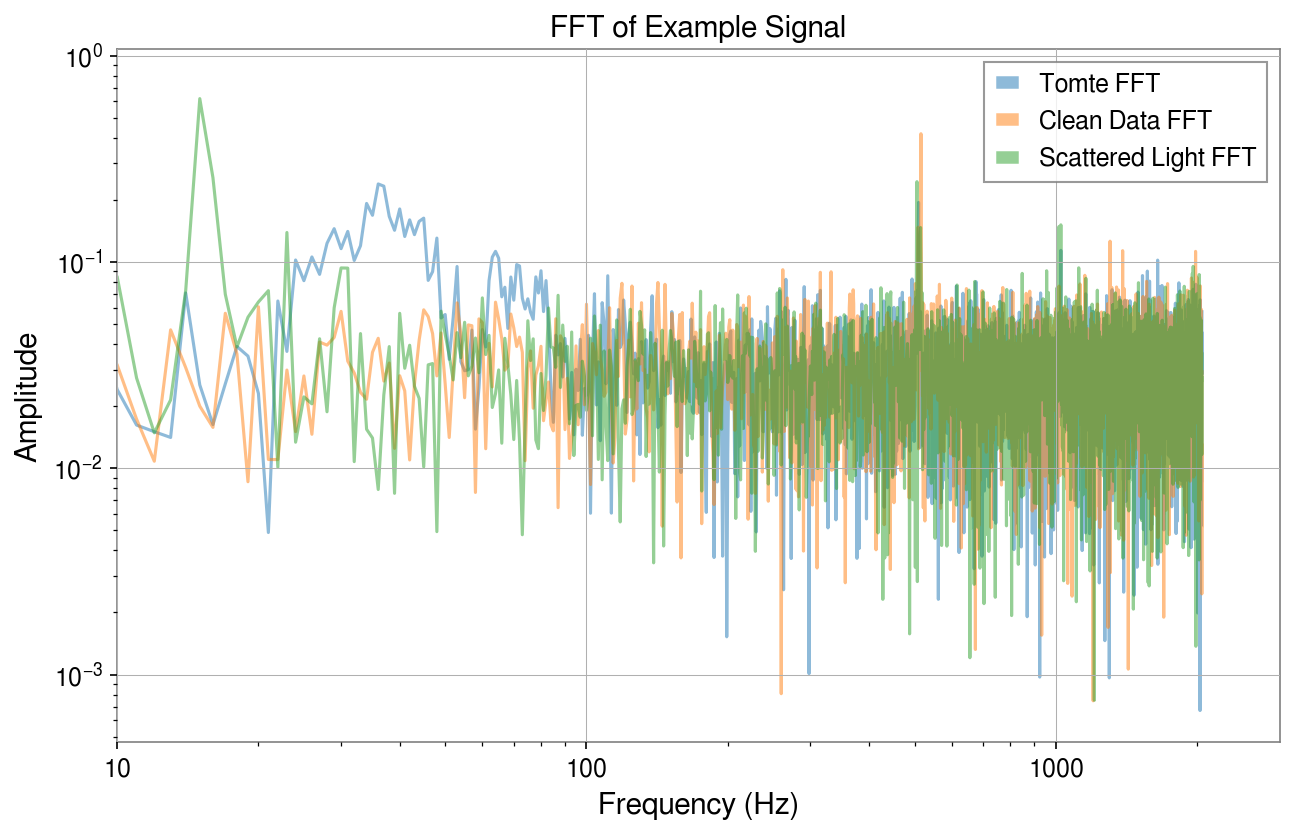

In [72]:
# Scattered Light
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(eg_fft.frequencies, np.abs(eg_fft.value), label="Tomte FFT", alpha=0.5)
plt.plot(eg_fft2.frequencies, np.abs(eg_fft2.value), label="Clean Data FFT", alpha=0.5)
plt.plot(eg_fft3.frequencies, np.abs(eg_fft3.value), label="Scattered Light FFT", alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlim(10)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("FFT of Example Signal")
plt.legend()
plt.show()

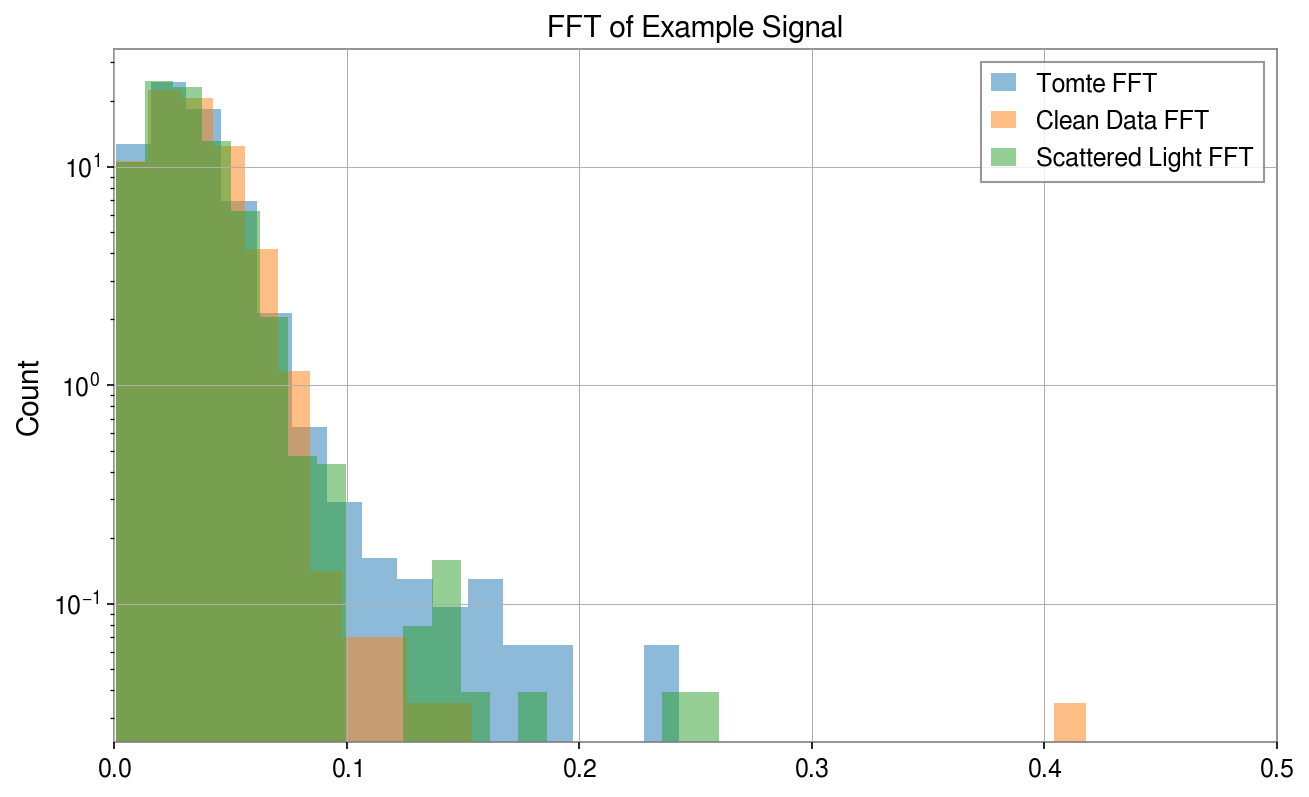

In [73]:
plt.figure(figsize=(10, 6), dpi=150)
plt.hist(np.abs(eg_fft.value), label="Tomte FFT", bins=50, density=True, alpha=0.5)
plt.hist(np.abs(eg_fft2.value), label="Clean Data FFT", bins=50, density=True, alpha=0.5)
plt.hist(np.abs(eg_fft3.value), label="Scattered Light FFT", bins=50, density=True, alpha=0.5)
plt.yscale('log')
plt.xlim(0,0.5)
plt.ylabel("Count")
plt.title("FFT of Example Signal")
plt.legend()
plt.show()

In [74]:
example

whitened_y                  [1.2005277799111047, 0.2652399595154659, 2.999...
t                           [1248235639.8398438 s, 1248235639.840088 s, 12...
timeseries_file_location    ./timeseries_data/sample_L1_1248235640.34_whit...
unwhitened_y                [-1.912832129443173e-19, -1.779985834789845e-1...
shapiro_statistic                                                     0.98371
shapiro_pvalue                                                        0.00000
ks_statistic                                                          0.02218
ks_pvalue                                                             0.03501
ad_statistic                                                          5.07267
ad_critical_values                        [0.575, 0.655, 0.786, 0.917, 1.091]
ad_significance_level                             [15.0, 10.0, 5.0, 2.5, 1.0]
kurtosis                                                              5.02047
skew                                                            

In [75]:
example2

whitened_y                  [-1.0445034733494019, -0.03988255036441557, -0...
t                           [1239082671.3659668 s, 1239082671.366211 s, 12...
timeseries_file_location    ./timeseries_data/sample_L1_cleanseg_123908266...
unwhitened_y                [5.438241096999612e-20, 4.962839640503188e-20,...
shapiro_statistic                                                     0.99916
shapiro_pvalue                                                        0.04550
ks_statistic                                                          0.00945
ks_pvalue                                                             0.85394
ad_statistic                                                          0.44434
ad_critical_values                        [0.575, 0.655, 0.786, 0.917, 1.091]
ad_significance_level                             [15.0, 10.0, 5.0, 2.5, 1.0]
kurtosis                                                              3.12244
skew                                                            

In [76]:
example3

whitened_y                  [0.17144254946917892, -0.4730252684957443, -2....
t                           [1253141883.125 s, 1253141883.1252441 s, 12531...
timeseries_file_location    ./timeseries_data/sample_L1_1253141883.625_whi...
unwhitened_y                [-1.9957965453186446e-19, -1.9340591362930947e...
shapiro_statistic                                                     0.99939
shapiro_pvalue                                                        0.19322
ks_statistic                                                          0.01524
ks_pvalue                                                             0.29473
ad_statistic                                                          0.51970
ad_critical_values                        [0.575, 0.655, 0.786, 0.917, 1.091]
ad_significance_level                             [15.0, 10.0, 5.0, 2.5, 1.0]
kurtosis                                                              3.06709
skew                                                            

In [77]:
eg_q_transform, eg_time = statistical_testing.calculate_q_transform(example_ts)
eg_q_transform2, eg_time2 = statistical_testing.calculate_q_transform(example_ts2)
eg_q_transform3, eg_time3 = statistical_testing.calculate_q_transform(example_ts3)

print(eg_time,eg_time2,eg_time3)

0.14406323432922363 0.1439528465270996 0.1627495288848877


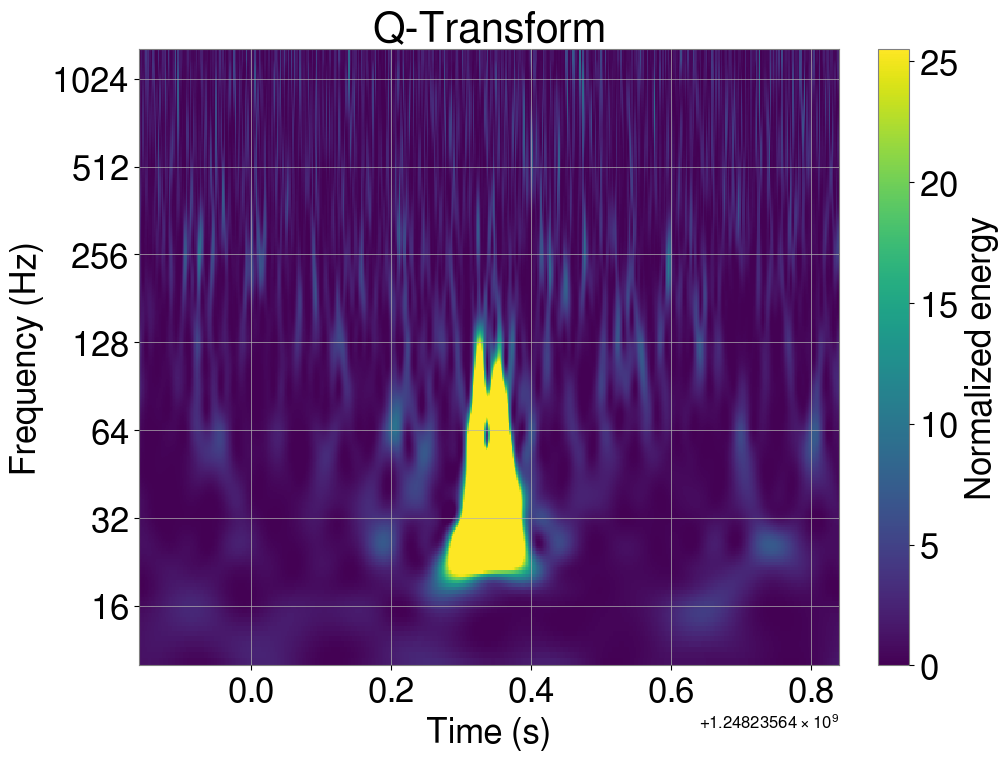

In [78]:
fig, ax = plt.subplots(1, figsize=(10, 8))
ax.imshow(eg_q_transform)
ax.set_yscale('log', base=2)
ax.set_xscale('linear')
ax.set_ylabel('Frequency (Hz)', fontsize=25)
ax.set_xlabel('Time (s)', fontsize=25)
ax.images[0].set_clim(0, 25.5)
ax.set_title("Q-Transform", fontsize=30)
ax.tick_params(axis='both', which="major", labelsize=25)
ax.tick_params(axis='both', which="minor", labelsize=25)
cbr = fig.colorbar(ax.images[0], ax=ax, label='Normalized energy', orientation='vertical', fraction=0.046, pad=0.05)
#set colorbar fontsize
cbr.set_label('Normalized energy', fontsize=25)
cbr.ax.tick_params(labelsize=25)

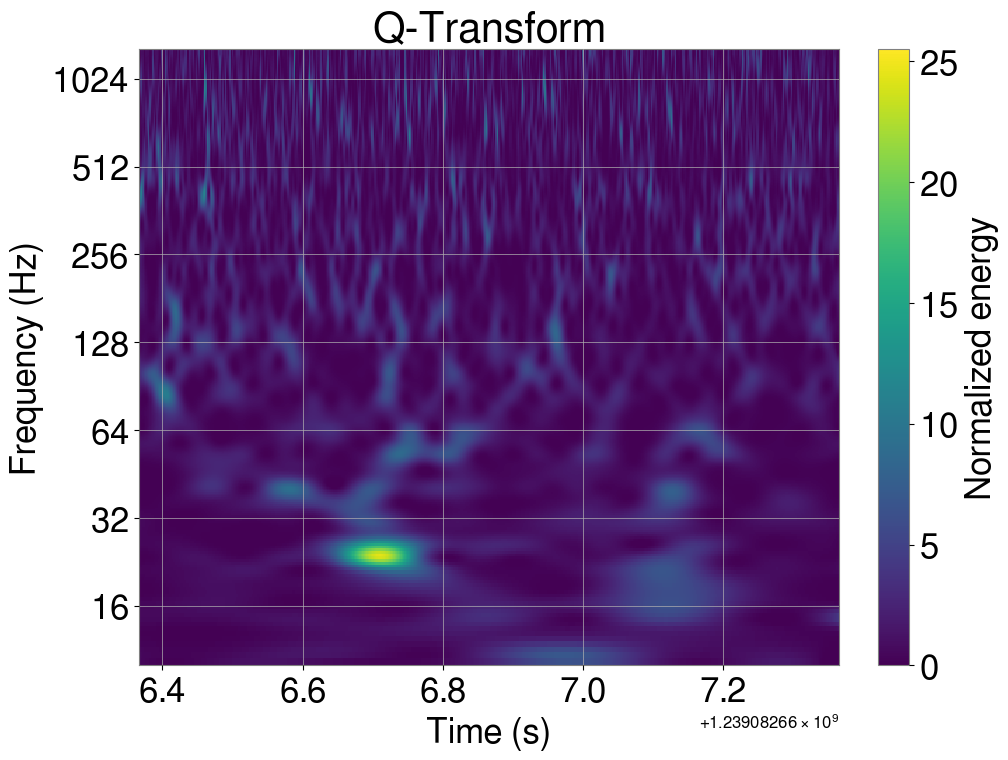

In [79]:
fig, ax = plt.subplots(1, figsize=(10, 8))
ax.imshow(eg_q_transform2)
ax.set_yscale('log', base=2)
ax.set_xscale('linear')
ax.set_ylabel('Frequency (Hz)', fontsize=25)
ax.set_xlabel('Time (s)', fontsize=25)
ax.images[0].set_clim(0, 25.5)
ax.set_title("Q-Transform", fontsize=30)
ax.tick_params(axis='both', which="major", labelsize=25)
ax.tick_params(axis='both', which="minor", labelsize=25)
cbr = fig.colorbar(ax.images[0], ax=ax, label='Normalized energy', orientation='vertical', fraction=0.046, pad=0.05)
#set colorbar fontsize
cbr.set_label('Normalized energy', fontsize=25)
cbr.ax.tick_params(labelsize=25)

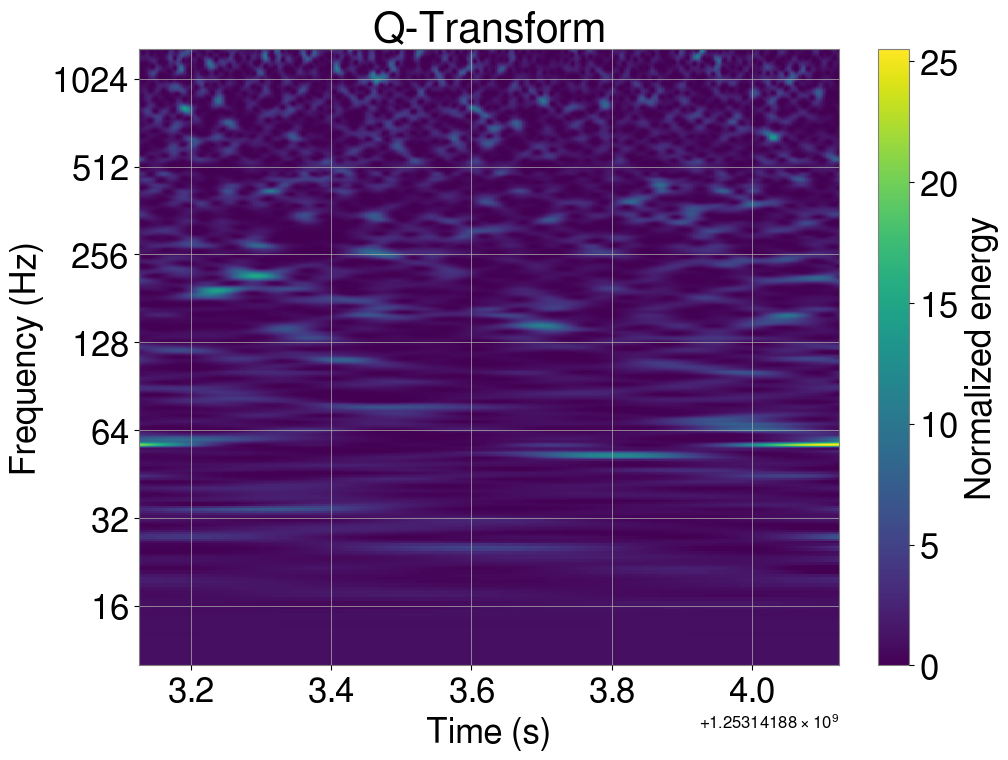

In [80]:
fig, ax = plt.subplots(1, figsize=(10, 8))
ax.imshow(eg_q_transform3)
ax.set_yscale('log', base=2)
ax.set_xscale('linear')
ax.set_ylabel('Frequency (Hz)', fontsize=25)
ax.set_xlabel('Time (s)', fontsize=25)
ax.images[0].set_clim(0, 25.5)
ax.set_title("Q-Transform", fontsize=30)
ax.tick_params(axis='both', which="major", labelsize=25)
ax.tick_params(axis='both', which="minor", labelsize=25)
cbr = fig.colorbar(ax.images[0], ax=ax, label='Normalized energy', orientation='vertical', fraction=0.046, pad=0.05)
#set colorbar fontsize
cbr.set_label('Normalized energy', fontsize=25)
cbr.ax.tick_params(labelsize=25)

# Plots for the report

1. Gaussian Distribution

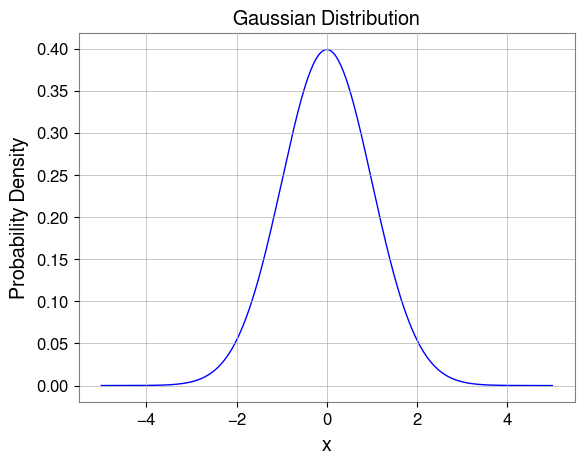

In [81]:
x = np.linspace(-5, 5, 1000)

mean = 0
stddev = 1

pdf = stats.norm.pdf(x, mean, stddev)

plt.plot(x, pdf, color='blue', linewidth=1)
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Gaussian Distribution')
plt.grid(True)
plt.savefig("./outputs/gaussian_distribution.pdf", dpi=100)

2. Speed comparison for generating Q-transforms for different TimeSeries lengths

In [82]:
from gwosc.datasets import event_gps

gw150914_gpstime = event_gps('GW150914')

window_sizes = [4, 6, 8, 10, 12, 14, 16, 18, 20]

q_transform_times = []

# Loading TimeSeries data for GW150914

for window_size in window_sizes:
    gw_ts = TimeSeries.fetch_open_data('L1', gw150914_gpstime - window_size, gw150914_gpstime + window_size)
    gw_ts = gw_ts[int(4096):-int(4096)]
    gw_ts = gw_ts.whiten(4, 2)
    _, time = statistical_testing.calculate_q_transform(gw_ts)
    q_transform_times.append(time)

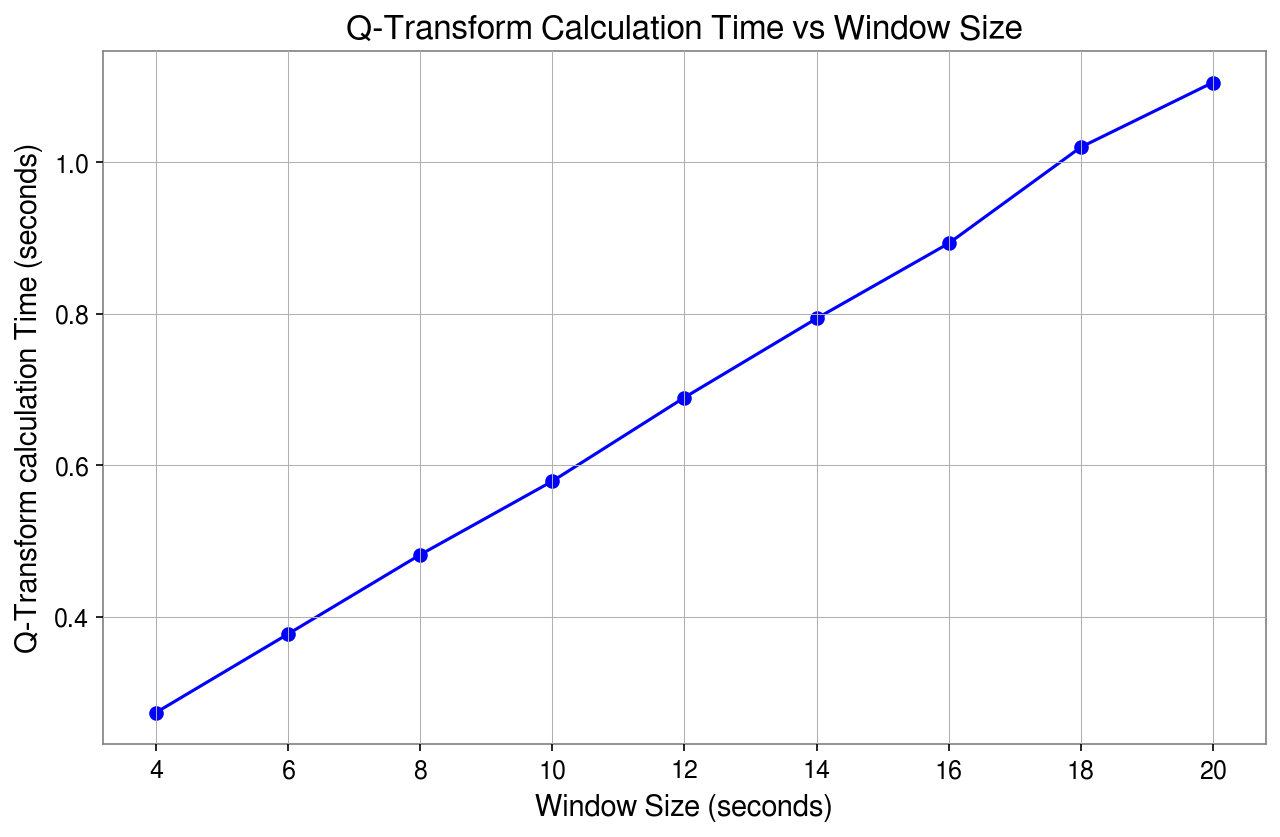

In [83]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
ax.plot(window_sizes, q_transform_times, marker='o', linestyle='-', color='blue')
ax.set_xlabel('Window Size (seconds)', fontsize=14)
ax.set_ylabel('Q-Transform calculation Time (seconds)', fontsize=14)
ax.set_title('Q-Transform Calculation Time vs Window Size', fontsize=16)
ax.grid(True)
plt.xticks(window_sizes)
plt.savefig("./outputs/q_transform_time_vs_window_size.pdf", dpi=100)

3. Speed comparison of generating Q-transforms at a constant sample length but increasing number of samples 

In [84]:
glitch_sample_df = combined_df.loc[combined_df['label'] != 'clean_signal']


sample_counts = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

q_transform_times = []

for sample_count in sample_counts:
    time = 0
    sample_df = glitch_sample_df.sample(sample_count)
    for index, row in sample_df.iterrows():
        ts = TimeSeries.read(row["timeseries_file_location"])
        ts = ts.whiten(4, 2)
        ts = ts[int(4096):-int(4096)]
        _, t = statistical_testing.calculate_q_transform(ts)
        time += t
    q_transform_times.append(time)

# example_ts3 = statistical_testing.get_sample_glitch_from_filepath(example3["timeseries_file_location"], observation_tw=5)[1]

KeyboardInterrupt: 

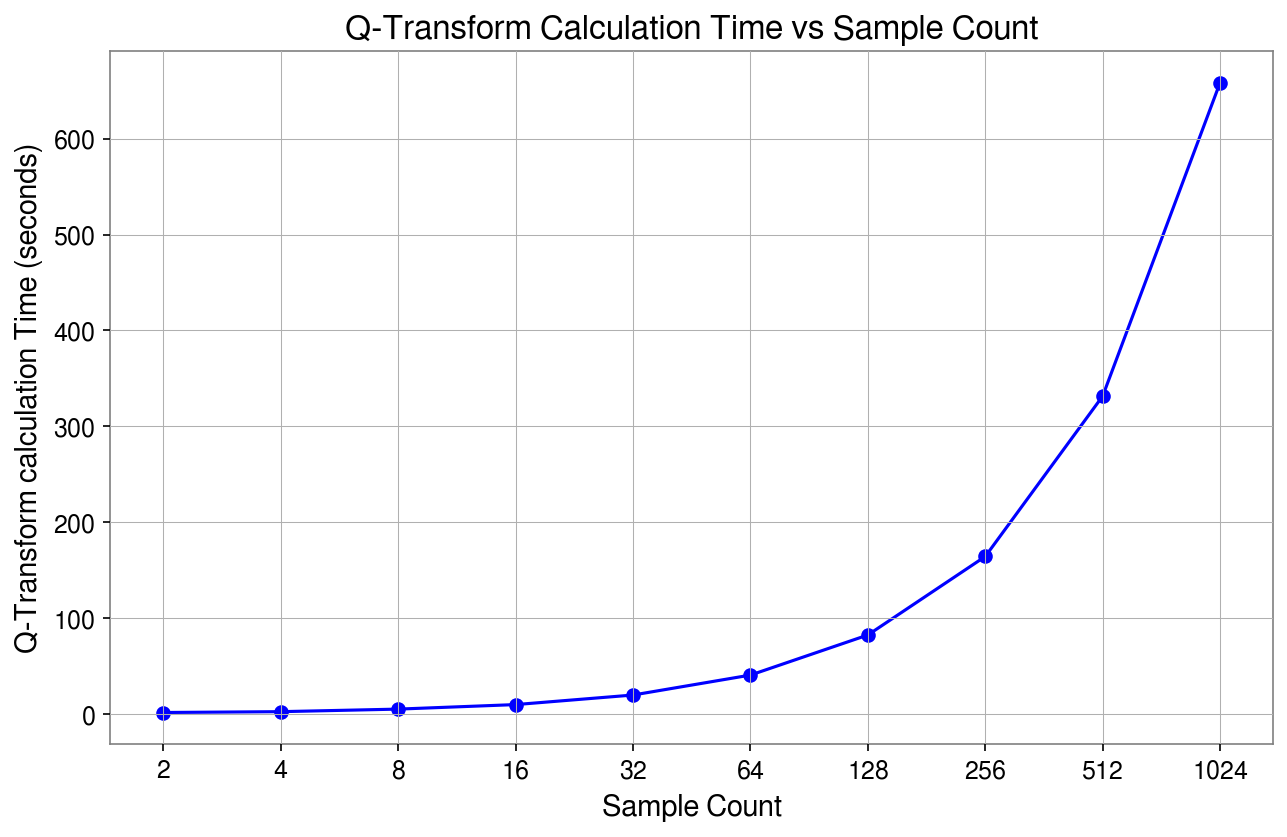

In [ ]:
from matplotlib.ticker import LogLocator

fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
ax.plot(sample_counts, q_transform_times, marker='o', linestyle='-', color='blue')
ax.set_xlabel('Sample Count', fontsize=14)
ax.set_ylabel('Q-Transform calculation Time (seconds)', fontsize=14)
ax.set_title('Q-Transform Calculation Time vs Sample Count', fontsize=16)
ax.grid(True)
ax.set_xscale('log', base=2)
ax.set_xticks(sample_counts)
plt.savefig("./outputs/q_transform_time_vs_sample_count.pdf", dpi=100)